In [1]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import math as m
import nuSQUIDSpy as nsq
import pisa
import h5py as hdf

<< PISA is running in double precision (FP64) mode; numba is running on CPU (single core) >>


In [2]:
from pisa.core.distribution_maker import DistributionMaker

## Checking PID cut

In [3]:
FLERCNN_vars = {'reco_coszen':'FLERCNN_coszen',
                'reco_energy':'FLERCNN_energy',
                'BDT_PID':'FLERCNN_plus_bdt_PID',
                'PID':'FLERCNN_prob_track',
                'weighted_aeff':'weighted_aeff',
                'livetime':'data_livetime',
                'ReferenceWeight':'ReferenceWeight',
                'true_energy':'MCInIcePrimary.energy',
                'pdg_code':'MCInIcePrimary.pdg_encoding',
                'BDT_y':'FLERCNN_plus_bdt_y',
                'bjorken_y':'I3GENIEResultDict.y',
                'true_rho36':'MCExtraTruthInfo.vertex_rho36',
                'true_coszen':'MCInIcePrimary.dir.coszen',
                'is_cc':'I3GENIEResultDict.cc',
                'is_nc':'I3GENIEResultDict.nc',
                'dis':'I3GENIEResultDict.dis',
                'interaction':'I3MCWeightDict.InteractionType',
}

CNN2D_vars = {'CNN2D_PID':'CNN2D_reco_PID.CNN2D_PID_prob_t',
              'new_lvl3_30gev_100rho':'CNN2D_reco_y.CNN2D_beta_lvl3_30gev_100rho36',
              'new_lvl3_5gev_100rho':'CNN2D_reco_y.CNN2D_beta_lvl3_5gev_100rho36',
              'old_lvl3_30gev_100rho':'CNN2D_reco_y.CNN2D_y_lvl3_30gev_100rho36',
              'old_lvl6_30gev_200rho':'CNN2D_reco_y.CNN2D_y_lvl6_30gev_200rho36',
              'old_lvl3_5gev_100rho':'CNN2D_reco_y.CNN2D_y_lvl3_5gev_100rho36',
              'old_lvl6_5gev_200rho':'CNN2D_reco_y.CNN2D_y_lvl6_5gev_200rho36',
}

Cuts_vars = {
    'reco_z':'FLERCNN_vertex_z',
    'reco_rho':'FLERCNN_vertex_rho36',
    'L7_CoincidentMuon_Variables.n_top15':'L7_CoincidentMuon_Variables.n_top15',
    'L7_CoincidentMuon_Variables.n_outer':'L7_CoincidentMuon_Variables.n_outer',
    'L5_SANTA_DirectPulsesHitMultiplicity.n_hit_doms':'L5_SANTA_DirectPulsesHitMultiplicity.n_hit_doms',
    'nDOM':'FLERCNN_nDOM',
    'l7_muon_classifier_prob_nu':'FLERCNN_BDT_ProbNu',
}

def GetCuts(group):
    z = group[Cuts_vars['reco_z']][:]
    rho = group[Cuts_vars['reco_rho']][:]
    ntop15 = group[Cuts_vars['L7_CoincidentMuon_Variables.n_top15']][:]
    nouter = group[Cuts_vars['L7_CoincidentMuon_Variables.n_outer']][:]
    nhitdoms = group[Cuts_vars['L5_SANTA_DirectPulsesHitMultiplicity.n_hit_doms']][:]
    ndom = group[Cuts_vars['nDOM']][:]
    probnu = group[Cuts_vars['l7_muon_classifier_prob_nu']][:]
    
    return ((z > -495.) & (z < -225.) &  (rho < 200) & (ntop15 < 0.5) & 
            (nouter < 7.5) & (nhitdoms > 2.5) & (ndom >= 7) & (probnu >= 0.8))

In [4]:
folder = '/afs/ifh.de/user/a/akumar/lustre/data/oscNext/flercnn_sample_inelasticity/'

In [5]:
pisahdf_filenames ={'0000':'oscNext_pisa_genie_0000_flercnn_plus.hdf5',
                    '1122':'oscNext_pisa_genie_1122_flercnn_plus.hdf5',
                    '1151':'oscNext_pisa_genie_1151_flercnn_plus.hdf5',
                    '1154':'oscNext_pisa_genie_1154_flercnn_plus.hdf5',
                    '121151':'FLERCNN_plus_121151.h5',
                    '141154':'FLERCNN_plus_141154.h5',
                    '161151':'FLERCNN_plus_161151.h5'
                   }

#1151 contains muons neutrinos
#1154 muon neutrinos + GEANT4
#FLERCNN_plus = old
#oscNext_pisa_genie = new

In [6]:
flercnnfolder = '/afs/ifh.de/user/a/akumar/lustre/data/oscNext/flercnn_sample_analysis/pisa_hdf5/flercnn/'

flercnnnames = {'neu':'oscNext_pisa_genie_0000_flercnn.hdf5',
                'muon':'oscNext_pisa_muongun_130000_flercnn.hdf5',
                'noise':'oscNext_pisa_noise_888003_flercnn.hdf5',
                'nominal':'oscNext_pisa_genie_1154_flercnn.hdf5'}

In [7]:
geant4 = hdf.File(folder+pisahdf_filenames['1154'],'r')

In [8]:
g4_weights = geant4['numu'][FLERCNN_vars['weighted_aeff']][:]

In [9]:
neu_1122 = hdf.File(folder+pisahdf_filenames['1122'],'r')

In [10]:
minEcut = 5
maxEcut = 300

nue_cc_minE_cuts = ((neu_1122['nue_cc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['nue_cc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))
nuebar_cc_minE_cuts = ((neu_1122['nuebar_cc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['nuebar_cc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))
nue_nc_minE_cuts = ((neu_1122['nue_nc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['nue_nc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))
nuebar_nc_minE_cuts = ((neu_1122['nuebar_nc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['nuebar_nc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))

numu_cc_minE_cuts = ((neu_1122['numu_cc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['numu_cc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))
numubar_cc_minE_cuts = ((neu_1122['numubar_cc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['numubar_cc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))
numu_nc_minE_cuts = ((neu_1122['numu_nc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['numu_nc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))
numubar_nc_minE_cuts = ((neu_1122['numubar_nc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['numubar_nc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))

nutau_cc_minE_cuts = ((neu_1122['nutau_cc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['nutau_cc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))
nutaubar_cc_minE_cuts = ((neu_1122['nutaubar_cc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['nutaubar_cc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))
nutau_nc_minE_cuts = ((neu_1122['nutau_nc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['nutau_nc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))
nutaubar_nc_minE_cuts = ((neu_1122['nutaubar_nc'][FLERCNN_vars['reco_energy']][:] >= minEcut) & 
                   (neu_1122['nutaubar_nc'][FLERCNN_vars['reco_energy']][:] <= maxEcut))

In [11]:
nue_cc_analysis_cuts = GetCuts(neu_1122['nue_cc'])
nuebar_cc_analysis_cuts = GetCuts(neu_1122['nuebar_cc'])
nue_nc_analysis_cuts = GetCuts(neu_1122['nue_nc'])
nuebar_nc_analysis_cuts = GetCuts(neu_1122['nuebar_nc'])

numu_cc_analysis_cuts = GetCuts(neu_1122['numu_cc'])
numubar_cc_analysis_cuts = GetCuts(neu_1122['numubar_cc'])
numu_nc_analysis_cuts = GetCuts(neu_1122['numu_nc'])
numubar_nc_analysis_cuts = GetCuts(neu_1122['numubar_nc'])

nutau_cc_analysis_cuts = GetCuts(neu_1122['nutau_cc'])
nutaubar_cc_analysis_cuts = GetCuts(neu_1122['nutaubar_cc'])
nutau_nc_analysis_cuts = GetCuts(neu_1122['nutau_nc'])
nutaubar_nc_analysis_cuts = GetCuts(neu_1122['nutaubar_nc'])

In [12]:
nutau_cc_PID = neu_1122['nutau_cc'][FLERCNN_vars['PID']][:]
nutaubar_cc_PID = neu_1122['nutaubar_cc'][FLERCNN_vars['PID']][:]
nutau_nc_PID = neu_1122['nutau_nc'][FLERCNN_vars['PID']][:]
nutaubar_nc_PID = neu_1122['nutaubar_nc'][FLERCNN_vars['PID']][:]
nue_cc_PID = neu_1122['nue_cc'][FLERCNN_vars['PID']][:]
nuebar_cc_PID = neu_1122['nuebar_cc'][FLERCNN_vars['PID']][:]
nue_nc_PID = neu_1122['nue_nc'][FLERCNN_vars['PID']][:]
nuebar_nc_PID = neu_1122['nuebar_nc'][FLERCNN_vars['PID']][:]
numu_cc_PID = neu_1122['numu_cc'][FLERCNN_vars['PID']][:]
numubar_cc_PID = neu_1122['numubar_cc'][FLERCNN_vars['PID']][:]
numu_nc_PID = neu_1122['numu_nc'][FLERCNN_vars['PID']][:]
numubar_nc_PID = neu_1122['numubar_nc'][FLERCNN_vars['PID']][:]

In [13]:
nutau_cc_weights = neu_1122['nutau_cc'][FLERCNN_vars['weighted_aeff']][:]
nutaubar_cc_weights = neu_1122['nutaubar_cc'][FLERCNN_vars['weighted_aeff']][:]
nutau_nc_weights = neu_1122['nutau_nc'][FLERCNN_vars['weighted_aeff']][:]
nutaubar_nc_weights = neu_1122['nutaubar_nc'][FLERCNN_vars['weighted_aeff']][:]
nue_cc_weights = neu_1122['nue_cc'][FLERCNN_vars['weighted_aeff']][:]
nuebar_cc_weights = neu_1122['nuebar_cc'][FLERCNN_vars['weighted_aeff']][:]
nue_nc_weights = neu_1122['nue_nc'][FLERCNN_vars['weighted_aeff']][:]
nuebar_nc_weights = neu_1122['nuebar_nc'][FLERCNN_vars['weighted_aeff']][:]
numu_cc_weights = neu_1122['numu_cc'][FLERCNN_vars['weighted_aeff']][:]
numubar_cc_weights = neu_1122['numubar_cc'][FLERCNN_vars['weighted_aeff']][:]
numu_nc_weights = neu_1122['numu_nc'][FLERCNN_vars['weighted_aeff']][:]
numubar_nc_weights = neu_1122['numubar_nc'][FLERCNN_vars['weighted_aeff']][:]

In [14]:
neu_1151 = hdf.File(folder+pisahdf_filenames['1151'],'r')

In [15]:
test_w = neu_1151['numu_nc']['weighted_aeff'][:]

In [16]:
test_w2 = neu_1122['numu_nc']['weighted_aeff'][:]

In [17]:
nutau_cc_true_energy = neu_1122['nutau_cc'][FLERCNN_vars['true_energy']][:]
nutaubar_cc_true_energy = neu_1122['nutaubar_cc'][FLERCNN_vars['true_energy']][:]
nutau_nc_true_energy = neu_1122['nutau_nc'][FLERCNN_vars['true_energy']][:]
nutaubar_nc_true_energy = neu_1122['nutaubar_nc'][FLERCNN_vars['true_energy']][:]
nue_cc_true_energy = neu_1122['nue_cc'][FLERCNN_vars['true_energy']][:]
nuebar_cc_true_energy = neu_1122['nuebar_cc'][FLERCNN_vars['true_energy']][:]
nue_nc_true_energy = neu_1122['nue_nc'][FLERCNN_vars['true_energy']][:]
nuebar_nc_true_energy = neu_1122['nuebar_nc'][FLERCNN_vars['true_energy']][:]
numu_cc_true_energy = neu_1122['numu_cc'][FLERCNN_vars['true_energy']][:]
numubar_cc_true_energy = neu_1122['numubar_cc'][FLERCNN_vars['true_energy']][:]
numu_nc_true_energy = neu_1122['numu_nc'][FLERCNN_vars['true_energy']][:]
numubar_nc_true_energy = neu_1122['numubar_nc'][FLERCNN_vars['true_energy']][:]

In [18]:
nutau_cc_true_coszen = neu_1122['nutau_cc'][FLERCNN_vars['true_coszen']][:]
nutaubar_cc_true_coszen = neu_1122['nutaubar_cc'][FLERCNN_vars['true_coszen']][:]
nutau_nc_true_coszen = neu_1122['nutau_nc'][FLERCNN_vars['true_coszen']][:]
nutaubar_nc_true_coszen = neu_1122['nutaubar_nc'][FLERCNN_vars['true_coszen']][:]
nue_cc_true_coszen = neu_1122['nue_cc'][FLERCNN_vars['true_coszen']][:]
nuebar_cc_true_coszen = neu_1122['nuebar_cc'][FLERCNN_vars['true_coszen']][:]
nue_nc_true_coszen = neu_1122['nue_nc'][FLERCNN_vars['true_coszen']][:]
nuebar_nc_true_coszen = neu_1122['nuebar_nc'][FLERCNN_vars['true_coszen']][:]
numu_cc_true_coszen = neu_1122['numu_cc'][FLERCNN_vars['true_coszen']][:]
numubar_cc_true_coszen = neu_1122['numubar_cc'][FLERCNN_vars['true_coszen']][:]
numu_nc_true_coszen = neu_1122['numu_nc'][FLERCNN_vars['true_coszen']][:]
numubar_nc_true_coszen = neu_1122['numubar_nc'][FLERCNN_vars['true_coszen']][:]

In [19]:
neu_1122_numu_cc_weights = neu_1122['numu_cc'][FLERCNN_vars['weighted_aeff']][:]
neu_1122_numubar_cc_weights = neu_1122['numubar_cc'][FLERCNN_vars['weighted_aeff']][:]
neu_1122_numu_nc_weights = neu_1122['numu_nc'][FLERCNN_vars['weighted_aeff']][:]
neu_1122_numubar_nc_weights = neu_1122['numubar_nc'][FLERCNN_vars['weighted_aeff']][:]

sum_neu_1122_numu_weights = (np.sum(neu_1122_numu_cc_weights) + 
                             np.sum(neu_1122_numubar_cc_weights) + 
                             np.sum(neu_1122_numu_nc_weights) + 
                             np.sum(neu_1122_numubar_nc_weights))

In [20]:
numu_pid=list(numu_cc_PID)+list(numubar_cc_PID)+list(numu_nc_PID)+list(numubar_nc_PID)
numu_weights=list(neu_1122_numu_cc_weights)+list(neu_1122_numubar_cc_weights)+list(neu_1122_numu_nc_weights)+list(neu_1122_numubar_nc_weights)

numu_pid=np.array(numu_pid)
numu_weights=np.array(numu_weights)

Text(0.5, 0, 'FLERCNN PID')

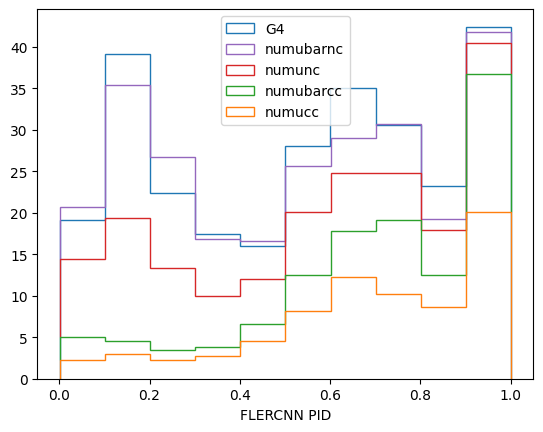

In [21]:
plt.hist(geant4['numu'][FLERCNN_vars['PID']][:],weights=geant4['numu'][FLERCNN_vars['weighted_aeff']][:],histtype='step',label='G4');

nus = (neu_1122['numu_cc'][FLERCNN_vars['PID']][:],
      neu_1122['numubar_cc'][FLERCNN_vars['PID']][:],
      neu_1122['numu_nc'][FLERCNN_vars['PID']][:],
      neu_1122['numubar_nc'][FLERCNN_vars['PID']][:])

ws = (neu_1122['numu_cc'][FLERCNN_vars['weighted_aeff']][:],
     neu_1122['numubar_cc'][FLERCNN_vars['weighted_aeff']][:],
     neu_1122['numu_nc'][FLERCNN_vars['weighted_aeff']][:],
     neu_1122['numubar_nc'][FLERCNN_vars['weighted_aeff']][:])

ls = ('numucc','numubarcc','numunc','numubarnc')

plt.hist(nus,weights=ws,histtype='step',stacked=True,label=ls);
plt.legend()
plt.xlabel('FLERCNN PID')

In [22]:
from neutrino_weighter_new_PISA import GENIENeutrinoWeighter_Backup

In [23]:
test_E = np.geomspace(1,1e4,200)
test_coszen = np.linspace(-1,1,50)

Es = []
coszs = []

for c in test_coszen:
    for E in test_E:
        Es.append(E)
        coszs.append(c)

Es = np.array(Es)
coszs = np.array(coszs)

In [24]:
fluxweights = GENIENeutrinoWeighter_Backup()

flav = [0,1,2]
nutype = [0,1] #0 nu, 1 nubar

nue_osc_flux_factor = fluxweights(Es,coszs,0,1,np.ones_like(Es))
nuebar_osc_flux_factor = fluxweights(Es,coszs,0,0,np.ones_like(Es))
numu_osc_flux_factor = fluxweights(Es,coszs,1,1,np.ones_like(Es))
numubar_osc_flux_factor = fluxweights(Es,coszs,1,0,np.ones_like(Es))
nutau_osc_flux_factor = fluxweights(Es,coszs,2,1,np.ones_like(Es))
nutaubar_osc_flux_factor = fluxweights(Es,coszs,2,0,np.ones_like(Es))

Calculating nominal nue flux
Calculating nominal numu flux
Calculating nominal nuebar flux
Calculating nominal numubar flux
Calculating oscillation probabilities...


TypeError: propagate_array() takes from 10 to 11 positional arguments but 9 were given

In [ ]:
(np.median(nue_osc_flux_factor/nuebar_osc_flux_factor),
np.median(numu_osc_flux_factor/numubar_osc_flux_factor),
np.median(nutau_osc_flux_factor/nutaubar_osc_flux_factor))

In [ ]:
(np.median(nue_osc_flux_factor),
np.median(numu_osc_flux_factor),
np.median(nutau_osc_flux_factor))

In [ ]:
(np.median(numu_osc_flux_factor/nue_osc_flux_factor),
 np.median(nue_osc_flux_factor/numu_osc_flux_factor),
 np.median(nutau_osc_flux_factor/nue_osc_flux_factor),
 np.median(nue_osc_flux_factor/nutau_osc_flux_factor), 
 np.median(nutau_osc_flux_factor/numu_osc_flux_factor),
 np.median(numu_osc_flux_factor/nutau_osc_flux_factor))

In [ ]:
import scipy.interpolate as sci

In [ ]:
interp_E_pts = np.log(test_E)
interp_cosz_pts = test_coszen
interp_values = nue_osc_flux_factor.reshape(200,50)

nue_flux_interp = sci.RegularGridInterpolator((interp_E_pts,interp_cosz_pts),
                                              nue_osc_flux_factor.reshape(200,50))
nuebar_flux_interp = sci.RegularGridInterpolator((interp_E_pts,interp_cosz_pts),
                                                     nuebar_osc_flux_factor.reshape(200,50))
numu_flux_interp = sci.RegularGridInterpolator((interp_E_pts,interp_cosz_pts),
                                              numu_osc_flux_factor.reshape(200,50))
numubar_flux_interp = sci.RegularGridInterpolator((interp_E_pts,interp_cosz_pts),
                                                     numubar_osc_flux_factor.reshape(200,50))
nutau_flux_interp = sci.RegularGridInterpolator((interp_E_pts,interp_cosz_pts),
                                              nutau_osc_flux_factor.reshape(200,50))
nutaubar_flux_interp = sci.RegularGridInterpolator((interp_E_pts,interp_cosz_pts),
                                                     nutaubar_osc_flux_factor.reshape(200,50))

In [ ]:
nue_cc_pts = np.array((np.log(nue_cc_true_energy),nue_cc_true_coszen)).T
nuebar_cc_pts = np.array((np.log(nuebar_cc_true_energy),nuebar_cc_true_coszen)).T
nue_nc_pts = np.array((np.log(nue_nc_true_energy),nue_nc_true_coszen)).T
nuebar_nc_pts = np.array((np.log(nuebar_nc_true_energy),nuebar_nc_true_coszen)).T

numu_cc_pts = np.array((np.log(numu_cc_true_energy),numu_cc_true_coszen)).T
numubar_cc_pts = np.array((np.log(numubar_cc_true_energy),numubar_cc_true_coszen)).T
numu_nc_pts = np.array((np.log(numu_nc_true_energy),numu_nc_true_coszen)).T
numubar_nc_pts = np.array((np.log(numubar_nc_true_energy),numubar_nc_true_coszen)).T

nutau_cc_pts = np.array((np.log(nutau_cc_true_energy),nutau_cc_true_coszen)).T
nutaubar_cc_pts = np.array((np.log(nutaubar_cc_true_energy),nutaubar_cc_true_coszen)).T
nutau_nc_pts = np.array((np.log(nutau_nc_true_energy),nutau_nc_true_coszen)).T
nutaubar_nc_pts = np.array((np.log(nutaubar_nc_true_energy),nutaubar_nc_true_coszen)).T

In [ ]:
np.median(numu_flux_interp(numu_cc_pts)),np.median(numu_osc_flux_factor)

In [ ]:
nue_cc_flux_osc_weights = nue_cc_weights * nue_flux_interp(nue_cc_pts)
nuebar_cc_flux_osc_weights = nuebar_cc_weights * nuebar_flux_interp(nuebar_cc_pts)
nue_nc_flux_osc_weights = nue_nc_weights * nue_flux_interp(nue_nc_pts)
nuebar_nc_flux_osc_weights = nuebar_nc_weights * nuebar_flux_interp(nuebar_nc_pts)

numu_cc_flux_osc_weights = numu_cc_weights * numu_flux_interp(numu_cc_pts)
numubar_cc_flux_osc_weights = numubar_cc_weights * numubar_flux_interp(numubar_cc_pts)
numu_nc_flux_osc_weights = numu_nc_weights * numu_flux_interp(numu_nc_pts)
numubar_nc_flux_osc_weights = numubar_nc_weights * numubar_flux_interp(numubar_nc_pts)

nutau_cc_flux_osc_weights = nutau_cc_weights * nutau_flux_interp(nutau_cc_pts)
nutaubar_cc_flux_osc_weights = nutaubar_cc_weights * nutaubar_flux_interp(nutaubar_cc_pts)
nutau_nc_flux_osc_weights = nutau_nc_weights * nutau_flux_interp(nutau_nc_pts)
nutaubar_nc_flux_osc_weights = nutaubar_nc_weights * nutaubar_flux_interp(nutaubar_nc_pts)

In [ ]:
binning = np.linspace(0,1,21)

signal = (numu_cc_PID, numubar_cc_PID)
signal_labels = ('numu_cc','numubar_cc')
signal_color = ('blue','darkblue')

numu_bkg = (numu_nc_PID, numubar_nc_PID)
numu_bkg_labels = ('numu_nc','numubar_nc')
numu_bkg_color = ('green','darkgreen')

other_bkg = (nue_cc_PID, nuebar_cc_PID, nue_nc_PID, nuebar_nc_PID, nutau_cc_PID, nutaubar_cc_PID, nutau_nc_PID, nutaubar_nc_PID)
other_bkg_labels = ('nue_cc','nuebar_cc','nue_nc','nuebar_nc','nutau_cc','nutaubar_cc','nutau_nc','nutaubar_nc')
other_bkg_color = ('orange','darkorange','red','darkred','violet','darkviolet','magenta','darkmagenta')

In [ ]:
signal_weights = (numu_cc_flux_osc_weights, numubar_cc_flux_osc_weights)
numu_bkg_weights = (numu_nc_flux_osc_weights, numubar_nc_flux_osc_weights)
other_bkg_weights = (nue_cc_flux_osc_weights, nuebar_cc_flux_osc_weights, nue_nc_flux_osc_weights, nuebar_nc_flux_osc_weights,
                    nutau_cc_flux_osc_weights, nutaubar_cc_flux_osc_weights, nutau_nc_flux_osc_weights, nutaubar_nc_flux_osc_weights)

In [ ]:
numus=(np.append(numu_cc_PID,numubar_cc_PID))
numus_weights=(np.append(numu_cc_flux_osc_weights,numubar_cc_flux_osc_weights))

plt.hist(numus,histtype='step',bins=binning)
plt.yscale('log')

In [ ]:
plot_PID = signal
plot_weights = signal_weights
plot_labels = signal_labels
plot_colors = signal_color

plt.hist(plot_PID,weights=plot_weights,histtype='bar',
         color=plot_colors,bins=binning,stacked=True,cumulative=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative Weighted Events')
plt.title('Stacked flux + osc. weighted nu/nubar events')
plt.legend()

In [ ]:
plot_PID = signal + numu_bkg
plot_weights = signal_weights + numu_bkg_weights
plot_labels = signal_labels + numu_bkg_labels
plot_colors = signal_color + numu_bkg_color

plt.hist(plot_PID,weights=plot_weights,histtype='bar',
         color=plot_colors,bins=binning,stacked=True,cumulative=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative Weighted Events')
plt.title('Stacked flux + osc. weighted nu/nubar events')
plt.legend()

In [ ]:
len(numu_cc_PID),len(numubar_cc_PID),len(numu_nc_PID),len(numubar_nc_PID),(len(numu_cc_PID)+
                                                                           len(numubar_cc_PID)+
                                                                           len(numu_nc_PID)+
                                                                           len(numubar_nc_PID))

In [ ]:
(np.median(numu_cc_flux_osc_weights),np.median(numubar_cc_flux_osc_weights),
 np.median(numu_nc_flux_osc_weights),np.median(numubar_nc_flux_osc_weights))

In [ ]:
(np.median(numu_cc_flux_osc_weights)/np.median(numu_nc_flux_osc_weights),np.median(numubar_cc_flux_osc_weights)/
 np.median(numubar_nc_flux_osc_weights))

In [ ]:
np.median(numu_cc_weights),np.median(numubar_cc_weights),np.median(numu_nc_weights),np.median(numubar_nc_weights)

In [ ]:
(len(numu_cc_PID)*np.median(numu_cc_flux_osc_weights),
 len(numubar_cc_PID)*np.median(numubar_cc_flux_osc_weights),
 len(numu_nc_PID)*np.median(numu_nc_flux_osc_weights),
 len(numubar_nc_PID)*np.median(numubar_nc_flux_osc_weights))

In [ ]:
(np.median(numu_flux_interp(numu_cc_pts)),
 np.median(numubar_flux_interp(numubar_cc_pts)),
 np.median(numu_flux_interp(numu_nc_pts)),
 np.median(numubar_flux_interp(numubar_nc_pts)))

In [ ]:
plot_PID = signal + numu_bkg + other_bkg
plot_weights = signal_weights + numu_bkg_weights + other_bkg_weights
plot_labels = signal_labels + numu_bkg_labels + other_bkg_labels
plot_colors = signal_color + numu_bkg_color + other_bkg_color

plt.hist(plot_PID,weights=plot_weights,histtype='bar',
         color=plot_colors,bins=binning,stacked=True,cumulative=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative Weighted Events')
plt.title('Stacked flux + osc. weighted nu/nubar events')
plt.legend()

In [ ]:
plt.hist(numu_cc_true_energy,histtype='step',bins=np.geomspace(1,1e4,51),label='numu_cc')
plt.hist(numubar_cc_true_energy,histtype='step',bins=np.geomspace(1,1e4,51),label='numubar_cc')
plt.hist(numu_nc_true_energy,histtype='step',bins=np.geomspace(1,1e4,51),label='numu_nc')
plt.hist(numubar_nc_true_energy,histtype='step',bins=np.geomspace(1,1e4,51),label='numubar_nc')

plt.xscale('log')
plt.xlabel('True Energy')
plt.legend()

In [ ]:
binning = np.linspace(0,1,21)

signal_acuts = (numu_cc_PID[numu_cc_analysis_cuts], numubar_cc_PID[numubar_cc_analysis_cuts])
signal_weights_acuts = (numu_cc_flux_osc_weights[numu_cc_analysis_cuts], numubar_cc_flux_osc_weights[numubar_cc_analysis_cuts])

numu_bkg_acuts = (numu_nc_PID[numu_nc_analysis_cuts], numubar_nc_PID[numubar_nc_analysis_cuts])
numu_bkg_weights_acuts = (numu_nc_flux_osc_weights[numu_nc_analysis_cuts], numubar_nc_flux_osc_weights[numubar_nc_analysis_cuts])

other_bkg_acuts = (nue_cc_PID[nue_cc_analysis_cuts], nuebar_cc_PID[nuebar_cc_analysis_cuts], 
                   nue_nc_PID[nue_nc_analysis_cuts], nuebar_nc_PID[nuebar_nc_analysis_cuts], 
                   nutau_cc_PID[nutau_cc_analysis_cuts], nutaubar_cc_PID[nutaubar_cc_analysis_cuts], 
                   nutau_nc_PID[nutau_nc_analysis_cuts], nutaubar_nc_PID[nutaubar_nc_analysis_cuts])

other_bkg_weights_acuts = (nue_cc_flux_osc_weights[nue_cc_analysis_cuts], nuebar_cc_flux_osc_weights[nuebar_cc_analysis_cuts], 
                           nue_nc_flux_osc_weights[nue_nc_analysis_cuts], nuebar_nc_flux_osc_weights[nuebar_nc_analysis_cuts],
                           nutau_cc_flux_osc_weights[nutau_cc_analysis_cuts], nutaubar_cc_flux_osc_weights[nutaubar_cc_analysis_cuts], 
                           nutau_nc_flux_osc_weights[nutau_nc_analysis_cuts], nutaubar_nc_flux_osc_weights[nutaubar_nc_analysis_cuts])

In [ ]:
plot_PID = signal_acuts + numu_bkg_acuts + other_bkg_acuts
plot_weights = signal_weights_acuts + numu_bkg_weights_acuts + other_bkg_weights_acuts
plot_labels = signal_labels + numu_bkg_labels + other_bkg_labels
plot_colors = signal_color + numu_bkg_color + other_bkg_color

plt.hist(plot_PID,weights=plot_weights,histtype='bar',
         color=plot_colors,bins=binning,stacked=True,cumulative=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative Weighted Events')
plt.title('Stacked flux, osc. weighted + Analysis Cuts nu/nubar events')
plt.legend(loc=2)

In [ ]:
plot_PID = signal + numu_bkg + other_bkg
plot_weights = signal_weights + numu_bkg_weights + other_bkg_weights
plot_labels = signal_labels + numu_bkg_labels + other_bkg_labels
plot_colors = signal_color + numu_bkg_color + other_bkg_color

plt.hist(plot_PID,histtype='bar',
         color=plot_colors,bins=binning,stacked=True,cumulative=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative Weighted Events')
plt.title('Stacked unweighted nu/nubar events')
plt.legend(loc=2)

In [ ]:
plot_PID = signal_acuts + numu_bkg_acuts + other_bkg_acuts
plot_weights = signal_weights_acuts + numu_bkg_weights_acuts + other_bkg_weights_acuts
plot_labels = signal_labels + numu_bkg_labels + other_bkg_labels
plot_colors = signal_color + numu_bkg_color + other_bkg_color

plt.hist(plot_PID,histtype='bar',
         color=plot_colors,bins=binning,stacked=True,cumulative=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative Weighted Events')
plt.title('Stacked unweighted + Analysis Cuts nu/nubar events')
plt.legend(loc=2)

In [ ]:
binning = np.linspace(0,1,21)

nue_cc_cut = nue_cc_analysis_cuts & nue_cc_minE_cuts
nuebar_cc_cut = nuebar_cc_analysis_cuts & nuebar_cc_minE_cuts
nue_nc_cut = nue_nc_analysis_cuts & nue_nc_minE_cuts
nuebar_nc_cut = nuebar_nc_analysis_cuts & nuebar_nc_minE_cuts

numu_cc_cut = numu_cc_analysis_cuts & numu_cc_minE_cuts
numubar_cc_cut = numubar_cc_analysis_cuts & numubar_cc_minE_cuts
numu_nc_cut = numu_nc_analysis_cuts & numu_nc_minE_cuts
numubar_nc_cut = numubar_nc_analysis_cuts & numubar_nc_minE_cuts

nutau_cc_cut = nutau_cc_analysis_cuts & nutau_cc_minE_cuts
nutaubar_cc_cut = nutaubar_cc_analysis_cuts & nutaubar_cc_minE_cuts
nutau_nc_cut = nutau_nc_analysis_cuts & nutau_nc_minE_cuts
nutaubar_nc_cut = nutaubar_nc_analysis_cuts & nutaubar_nc_minE_cuts

signal_aecuts = (numu_cc_PID[numu_cc_cut], numubar_cc_PID[numubar_cc_cut])
signal_weights_aecuts = (numu_cc_flux_osc_weights[numu_cc_cut], numubar_cc_flux_osc_weights[numubar_cc_cut])

numu_bkg_aecuts = (numu_nc_PID[numu_nc_cut], numubar_nc_PID[numubar_nc_cut])
numu_bkg_weights_aecuts = (numu_nc_flux_osc_weights[numu_nc_cut], numubar_nc_flux_osc_weights[numubar_nc_cut])

other_bkg_aecuts = (nue_cc_PID[nue_cc_cut], nuebar_cc_PID[nuebar_cc_cut], 
                   nue_nc_PID[nue_nc_cut], nuebar_nc_PID[nuebar_nc_cut], 
                   nutau_cc_PID[nutau_cc_cut], nutaubar_cc_PID[nutaubar_cc_cut], 
                   nutau_nc_PID[nutau_nc_cut], nutaubar_nc_PID[nutaubar_nc_cut])

other_bkg_weights_aecuts = (nue_cc_flux_osc_weights[nue_cc_cut], nuebar_cc_flux_osc_weights[nuebar_cc_cut], 
                           nue_nc_flux_osc_weights[nue_nc_cut], nuebar_nc_flux_osc_weights[nuebar_nc_cut],
                           nutau_cc_flux_osc_weights[nutau_cc_cut], nutaubar_cc_flux_osc_weights[nutaubar_cc_cut], 
                           nutau_nc_flux_osc_weights[nutau_nc_cut], nutaubar_nc_flux_osc_weights[nutaubar_nc_cut])

In [ ]:
plt.hist(signal_acuts,histtype='bar',weights=signal_weights_acuts,
         color=signal_color,stacked=True,bins=np.linspace(0,1,21),label=plot_labels)
plt.yscale('log')

In [ ]:
plot_PID = signal_aecuts + numu_bkg_aecuts
plot_weights = signal_weights_aecuts + numu_bkg_weights_aecuts
plot_labels = signal_labels + numu_bkg_labels
plot_colors = signal_color + numu_bkg_color

plt.hist(plot_PID,histtype='bar',weights=plot_weights,
         color=plot_colors,bins=binning,stacked=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative Weighted Events')
plt.title('Stacked flux + osc. weighted nu/nubar events'+ '\n'+r'Analysis Cuts and E$_{reco} \geq $ 5 GeV')
plt.legend(loc=2)

In [ ]:
plot_PID = signal_aecuts + numu_bkg_aecuts + other_bkg_aecuts
plot_weights = signal_weights_aecuts + numu_bkg_weights_aecuts + other_bkg_weights_aecuts
plot_labels = signal_labels + numu_bkg_labels + other_bkg_labels
plot_colors = signal_color + numu_bkg_color + other_bkg_color

plt.hist(plot_PID,histtype='bar',weights=plot_weights,
         color=plot_colors,bins=binning,stacked=True,cumulative=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative Weighted Events')
plt.title('Stacked flux + osc. weighted nu/nubar events'+ '\n'+r'Analysis Cuts and 5 GeV $\leq $ E$_{reco} \leq $ 300 GeV')
plt.legend(loc=2)

In [ ]:
for w in plot_weights:
    print(np.mean(w))

In [ ]:
plot_PID = signal_aecuts + numu_bkg_aecuts + other_bkg_aecuts
plot_weights = signal_weights_aecuts + numu_bkg_weights_aecuts + other_bkg_weights_aecuts
plot_labels = signal_labels + numu_bkg_labels + other_bkg_labels
plot_colors = signal_color + numu_bkg_color + other_bkg_color

plt.hist(plot_PID,histtype='bar',weights=plot_weights,
         color=plot_colors,bins=binning,stacked=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Weighted Events [1/s]')
plt.title('Stacked flux + osc. weighted nu/nubar events'+ '\n'+r'Analysis Cuts and 5 GeV $\leq $E$_{reco} \leq $ 300 GeV')
plt.legend(loc=2)

In [ ]:
totl=0
for i in plot_PID:
    totl+=len(i)
totl

In [ ]:
plot_PID = signal_aecuts + numu_bkg_aecuts + other_bkg_aecuts
plot_weights = signal_weights_aecuts + numu_bkg_weights_aecuts + other_bkg_weights_aecuts

plotweights_normed = list(np.zeros((12,)))
for i,weight in enumerate(plot_weights):
    plotweights_normed[i]=weight/np.sum(weight)
plotweights_normed=tuple(plotweights_normed)
    
plot_labels = signal_labels + numu_bkg_labels + other_bkg_labels
plot_colors = signal_color + numu_bkg_color + other_bkg_color

plt.hist(plot_PID,histtype='step',weights=plotweights_normed,
         color=plot_colors,bins=binning,cumulative=True,stacked=False,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative weighted Events [1/s]')
plt.title('Stacked flux + osc. weighted nu/nubar events'+ '\n'+r'Analysis Cuts and 5 GeV $\leq $E$_{reco} \leq $ 300 GeV')
plt.legend(loc=2)

In [ ]:
l=0
totl=0
for k in neu_1122.keys():
    l=len(neu_1122[k]['weighted_aeff'][:])
    totl+=l
    print(l,totl)

### Proper Flux Weights

In [ ]:
weight_file = hdf.File('FluxOscWeights/fluxoscweights.h5','r')

In [ ]:
proper_flux_osc_weights_nue_cc = weight_file['nue_cc_osc_flux_weights'][:]
proper_flux_osc_weights_nuebar_cc = weight_file['nuebar_cc_osc_flux_weights'][:]
proper_flux_osc_weights_nue_nc = weight_file['nue_nc_osc_flux_weights'][:]
proper_flux_osc_weights_nuebar_nc = weight_file['nuebar_nc_osc_flux_weights'][:]

proper_flux_osc_weights_numu_cc = weight_file['numu_cc_osc_flux_weights'][:]
proper_flux_osc_weights_numubar_cc = weight_file['numubar_cc_osc_flux_weights'][:]
proper_flux_osc_weights_numu_nc = weight_file['numu_nc_osc_flux_weights'][:]
proper_flux_osc_weights_numubar_nc = weight_file['numubar_nc_osc_flux_weights'][:]

proper_flux_osc_weights_nutau_cc = weight_file['nutau_cc_osc_flux_weights'][:]
proper_flux_osc_weights_nutaubar_cc = weight_file['nutaubar_cc_osc_flux_weights'][:]
proper_flux_osc_weights_nutau_nc = weight_file['nutau_nc_osc_flux_weights'][:]
proper_flux_osc_weights_nutaubar_nc = weight_file['nutaubar_nc_osc_flux_weights'][:]

In [ ]:
proper_signal_weights = (proper_flux_osc_weights_numu_cc, proper_flux_osc_weights_numubar_cc)
proper_numu_bkg_weights = (proper_flux_osc_weights_numu_nc, proper_flux_osc_weights_numubar_nc)
proper_other_bkg_weights = (proper_flux_osc_weights_nue_cc, proper_flux_osc_weights_nuebar_cc, 
                     proper_flux_osc_weights_nue_nc, proper_flux_osc_weights_nuebar_nc,
                     proper_flux_osc_weights_nutau_cc, proper_flux_osc_weights_nutaubar_cc, 
                     proper_flux_osc_weights_nutau_nc, proper_flux_osc_weights_nutaubar_nc)

In [ ]:
len(signal[1]),len(proper_signal_weights[1])

In [ ]:
plot_PID = signal + numu_bkg + other_bkg
proper_plot_weights = proper_signal_weights + proper_numu_bkg_weights + proper_other_bkg_weights
plot_labels = signal_labels + numu_bkg_labels + other_bkg_labels
plot_colors = signal_color + numu_bkg_color + other_bkg_color

plt.hist(plot_PID,histtype='bar',weights=proper_plot_weights,
         color=plot_colors,bins=binning,stacked=True,cumulative=False,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Weighted Event Rate [1/s]')
plt.title('Proper flux + osc. weighted nu/nubar events')
plt.legend(loc=2)

In [ ]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=x, lw=2) for x in plot_colors]

In [ ]:
pid_array = [x for x in plot_PID]
pid_weight_norm_array = [x/np.sum(x) for x in proper_plot_weights]
label_array = [x for x in plot_labels]
color_array = [x for x in plot_colors]

for num in range(len(pid_array)):
    plt.hist(pid_array[num],histtype='step',weights=pid_weight_norm_array[num],color=color_array[num],
            bins=np.linspace(0,1,51),cumulative=True,label=label_array[num])

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative nu/nubar distribution')
plt.title('Flux + osc. weighted nu/nubar events')
plt.legend(custom_lines,label_array,loc=2,fontsize=8)

In [ ]:
plt.hist(neu_1122['numu_nc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_numu_nc
         /np.sum(proper_flux_osc_weights_numu_nc),bins=np.geomspace(1,1e3,51),label='numu_nc',histtype='step',color='blue');
plt.hist(neu_1122['numubar_nc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_numubar_nc
         /np.sum(proper_flux_osc_weights_numubar_nc),bins=np.geomspace(1,1e3,51),label='numubar_nc',histtype='step',color='darkblue');
plt.hist(neu_1122['nue_cc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_nue_cc
         /np.sum(proper_flux_osc_weights_nue_cc),bins=np.geomspace(1,1e3,51),label='nue_cc',histtype='step',color='green');
plt.hist(neu_1122['nuebar_cc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_nuebar_cc
         /np.sum(proper_flux_osc_weights_nuebar_cc),bins=np.geomspace(1,1e3,51),label='nuebar_cc',histtype='step',color='darkgreen');
plt.hist(neu_1122['nue_nc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_nue_nc
         /np.sum(proper_flux_osc_weights_nue_nc),bins=np.geomspace(1,1e3,51),label='nue_nc',histtype='step',color='lime');
plt.hist(neu_1122['nuebar_nc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_nuebar_nc
         /np.sum(proper_flux_osc_weights_nuebar_nc),bins=np.geomspace(1,1e3,51),label='nuebar_nc',histtype='step',color='limegreen');
plt.hist(neu_1122['nutau_cc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_nutau_cc
         /np.sum(proper_flux_osc_weights_nutau_cc),bins=np.geomspace(1,1e3,51),label='nutau_cc',histtype='step',color='orange');
plt.hist(neu_1122['nutaubar_cc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_nutaubar_cc
         /np.sum(proper_flux_osc_weights_nutaubar_cc),bins=np.geomspace(1,1e3,51),label='nutaubar_cc',histtype='step',color='darkorange');
plt.hist(neu_1122['nutau_nc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_nutau_nc
         /np.sum(proper_flux_osc_weights_nutau_nc),bins=np.geomspace(1,1e3,51),label='nutau_nc',histtype='step',color='red');
plt.hist(neu_1122['nutaubar_nc'][FLERCNN_vars['reco_energy']],weights=proper_flux_osc_weights_nutaubar_nc
         /np.sum(proper_flux_osc_weights_nutaubar_nc),bins=np.geomspace(1,1e3,51),label='nutaubar_nc',histtype='step',color='darkred');
plt.xlabel('E_reco')
plt.xscale('log')
plt.ylabel('Normalized Rate')
plt.title('Flux + osc. weighted')
plt.legend(fontsize=8)

In [ ]:
split_weight_file = hdf.File('FluxOscWeights/weights_splitfactors.h5','r')

In [ ]:
numu_nc_prob = split_weight_file['numu_nc_probfactor'][:]
numu_nc_flux = split_weight_file['numu_nc_fluxfactor'][:]
numu_nc_aeff = split_weight_file['numu_nc_aefffactor'][:]

numubar_nc_prob = split_weight_file['numubar_nc_probfactor'][:]
numubar_nc_flux = split_weight_file['numubar_nc_fluxfactor'][:]
numubar_nc_aeff = split_weight_file['numubar_nc_aefffactor'][:]

nue_nc_prob = split_weight_file['nue_nc_probfactor'][:]
nue_nc_flux = split_weight_file['nue_nc_fluxfactor'][:]
nue_nc_aeff = split_weight_file['nue_nc_aefffactor'][:]

nuebar_nc_prob = split_weight_file['nuebar_nc_probfactor'][:]
nuebar_nc_flux = split_weight_file['nuebar_nc_fluxfactor'][:]
nuebar_nc_aeff = split_weight_file['nuebar_nc_aefffactor'][:]

nue_cc_prob = split_weight_file['nue_cc_probfactor'][:]
nue_cc_flux = split_weight_file['nue_cc_fluxfactor'][:]
nue_cc_aeff = split_weight_file['nue_cc_aefffactor'][:]

nuebar_cc_prob = split_weight_file['nuebar_cc_probfactor'][:]
nuebar_cc_flux = split_weight_file['nuebar_cc_fluxfactor'][:]
nuebar_cc_aeff = split_weight_file['nuebar_cc_aefffactor'][:]

nutau_nc_prob = split_weight_file['nutau_nc_probfactor'][:]
nutau_nc_flux = split_weight_file['nutau_nc_fluxfactor'][:]
nutau_nc_aeff = split_weight_file['nutau_nc_aefffactor'][:]

nutaubar_nc_prob = split_weight_file['nutaubar_nc_probfactor'][:]
nutaubar_nc_flux = split_weight_file['nutaubar_nc_fluxfactor'][:]
nutaubar_nc_aeff = split_weight_file['nutaubar_nc_aefffactor'][:]

nutau_cc_prob = split_weight_file['nutau_cc_probfactor'][:]
nutau_cc_flux = split_weight_file['nutau_cc_fluxfactor'][:]
nutau_cc_aeff = split_weight_file['nutau_cc_aefffactor'][:]

nutaubar_cc_prob = split_weight_file['nutaubar_cc_probfactor'][:]
nutaubar_cc_flux = split_weight_file['nutaubar_cc_fluxfactor'][:]
nutaubar_cc_aeff = split_weight_file['nutaubar_cc_aefffactor'][:]

In [ ]:
numu_nc_w = numu_nc_aeff[1]
numu_nc_wf = numu_nc_aeff[1] * numu_nc_flux[1]
numu_nc_wfp = np.sum(numu_nc_aeff[1] * numu_nc_prob * numu_nc_flux,axis=0)

numubar_nc_w = numubar_nc_aeff[1]
numubar_nc_wf = numubar_nc_aeff[1] * numubar_nc_flux[1]
numubar_nc_wfp = np.sum(numubar_nc_aeff[1] * numubar_nc_prob * numubar_nc_flux,axis=0)

nue_cc_w = nue_cc_aeff[1]
nue_cc_wf = nue_cc_aeff[1] * nue_cc_flux[0]
nue_cc_wfp = np.sum(nue_cc_aeff[1] * nue_cc_prob * nue_cc_flux,axis=0)

nuebar_cc_w = nuebar_cc_aeff[1]
nuebar_cc_wf = nuebar_cc_aeff[1] * nuebar_cc_flux[0]
nuebar_cc_wfp = np.sum(nuebar_cc_aeff[1] * nuebar_cc_prob * nuebar_cc_flux,axis=0)

nue_nc_w = nue_nc_aeff[1]
nue_nc_wf = nue_nc_aeff[1] * nue_nc_flux[0]
nue_nc_wfp = np.sum(nue_nc_aeff[1] * nue_nc_prob * nue_nc_flux,axis=0)

nuebar_nc_w = nuebar_nc_aeff[1]
nuebar_nc_wf = nuebar_nc_aeff[1] * nuebar_nc_flux[0]
nuebar_nc_wfp = np.sum(nuebar_nc_aeff[1] * nuebar_nc_prob * nuebar_nc_flux,axis=0)

nutau_cc_w = nutau_cc_aeff[1]
nutau_cc_wf = np.zeros_like(nutau_cc_aeff[1] * nutau_cc_flux[0])
nutau_cc_wfp = np.sum(nutau_cc_aeff[1] * nutau_cc_prob * nutau_cc_flux,axis=0)

nutaubar_cc_w = nutaubar_cc_aeff[1]
nutaubar_cc_wf = np.zeros_like(nutaubar_cc_aeff[1] * nutaubar_cc_flux[0])
nutaubar_cc_wfp = np.sum(nutaubar_cc_aeff[1] * nutaubar_cc_prob * nutaubar_cc_flux,axis=0)

nutau_nc_w = nutau_nc_aeff[1]
nutau_nc_wf = np.zeros_like(nutau_nc_aeff[1] * nutau_nc_flux[0])
nutau_nc_wfp = np.sum(nutau_nc_aeff[1] * nutau_nc_prob * nutau_nc_flux,axis=0)

nutaubar_nc_w = nutaubar_nc_aeff[1]
nutaubar_nc_wf = np.zeros_like(nutaubar_nc_aeff[1] * nutaubar_nc_flux[0])
nutaubar_nc_wfp = np.sum(nutaubar_nc_aeff[1] * nutaubar_nc_prob * nutaubar_nc_flux,axis=0)

In [ ]:
neu_0000 = hdf.File(folder+pisahdf_filenames['0000'],'r')

In [ ]:
plt.hist(neu_0000['numu_nc'][FLERCNN_vars['reco_energy']],weights=numu_nc_wf
         /np.sum(numu_nc_wf),bins=np.geomspace(1,1e3,51),label='numu_nc',histtype='step',color='blue');
plt.hist(neu_0000['numubar_nc'][FLERCNN_vars['reco_energy']],weights=numubar_nc_wf
         /np.sum(numubar_nc_wf),bins=np.geomspace(1,1e3,51),label='numubar_nc',histtype='step',color='darkblue');
plt.hist(neu_0000['nue_cc'][FLERCNN_vars['reco_energy']],weights=nue_cc_wf
         /np.sum(nue_cc_wf),bins=np.geomspace(1,1e3,51),label='nue_cc',histtype='step',color='green');
plt.hist(neu_0000['nuebar_cc'][FLERCNN_vars['reco_energy']],weights=nuebar_cc_wf
         /np.sum(nuebar_cc_wf),bins=np.geomspace(1,1e3,51),label='nuebar_cc',histtype='step',color='darkgreen');
plt.hist(neu_0000['nue_nc'][FLERCNN_vars['reco_energy']],weights=nue_nc_wf
         /np.sum(nue_nc_wf),bins=np.geomspace(1,1e3,51),label='nue_nc',histtype='step',color='lime');
plt.hist(neu_0000['nuebar_nc'][FLERCNN_vars['reco_energy']],weights=nuebar_nc_wf
         /np.sum(nuebar_nc_wf),bins=np.geomspace(1,1e3,51),label='nuebar_nc',histtype='step',color='limegreen');
plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']],weights=nutau_cc_wf
         /np.sum(nutau_cc_wf),bins=np.geomspace(1,1e3,51),label='nutau_cc',histtype='step',color='orange');
plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']],weights=nutaubar_cc_wf
         /np.sum(nutaubar_cc_wf),bins=np.geomspace(1,1e3,51),label='nutaubar_cc',histtype='step',color='darkorange');
plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']],weights=nutau_nc_wf
         /np.sum(nutau_nc_wf),bins=np.geomspace(1,1e3,51),label='nutau_nc',histtype='step',color='red');
plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']],weights=nutaubar_nc_wf
         /np.sum(nutaubar_nc_wf),bins=np.geomspace(1,1e3,51),label='nutaubar_nc',histtype='step',color='darkred');
plt.xlabel('E_reco')
plt.xscale('log')
plt.ylabel('Normalized Rate')
plt.title('Flux weighted')
plt.legend(fontsize=8)
plt.show()

plt.hist(neu_0000['numu_nc'][FLERCNN_vars['reco_energy']],weights=numu_nc_wfp
         /np.sum(numu_nc_wfp),bins=np.geomspace(1,1e3,51),label='numu_nc',histtype='step',color='blue');
plt.hist(neu_0000['numubar_nc'][FLERCNN_vars['reco_energy']],weights=numubar_nc_wfp
         /np.sum(numubar_nc_wfp),bins=np.geomspace(1,1e3,51),label='numubar_nc',histtype='step',color='darkblue');
plt.hist(neu_0000['nue_cc'][FLERCNN_vars['reco_energy']],weights=nue_cc_wfp
         /np.sum(nue_cc_wfp),bins=np.geomspace(1,1e3,51),label='nue_cc',histtype='step',color='green');
plt.hist(neu_0000['nuebar_cc'][FLERCNN_vars['reco_energy']],weights=nuebar_cc_wfp
         /np.sum(nuebar_cc_wfp),bins=np.geomspace(1,1e3,51),label='nuebar_cc',histtype='step',color='darkgreen');
plt.hist(neu_0000['nue_nc'][FLERCNN_vars['reco_energy']],weights=nue_nc_wfp
         /np.sum(nue_nc_wfp),bins=np.geomspace(1,1e3,51),label='nue_nc',histtype='step',color='lime');
plt.hist(neu_0000['nuebar_nc'][FLERCNN_vars['reco_energy']],weights=nuebar_nc_wfp
         /np.sum(nuebar_nc_wfp),bins=np.geomspace(1,1e3,51),label='nuebar_nc',histtype='step',color='limegreen');
plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']],weights=nutau_cc_wfp
         /np.sum(nutau_cc_wfp),bins=np.geomspace(1,1e3,51),label='nutau_cc',histtype='step',color='orange');
plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']],weights=nutaubar_cc_wfp
         /np.sum(nutaubar_cc_wfp),bins=np.geomspace(1,1e3,51),label='nutaubar_cc',histtype='step',color='darkorange');
plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']],weights=nutau_nc_wfp
         /np.sum(nutau_nc_wfp),bins=np.geomspace(1,1e3,51),label='nutau_nc',histtype='step',color='red');
plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']],weights=nutaubar_nc_wfp
         /np.sum(nutaubar_nc_wfp),bins=np.geomspace(1,1e3,51),label='nutaubar_nc',histtype='step',color='darkred');
plt.xlabel('E_reco')
plt.xscale('log')
plt.ylabel('Normalized Rate')
plt.title('Flux + osc. weighted')
plt.legend(fontsize=8)
plt.show()

In [ ]:
plt.hist(neu_0000['numu_nc'][FLERCNN_vars['reco_energy']],weights=numu_nc_wf
         /np.sum(numu_nc_wf),bins=np.geomspace(1,1e3,51),label='numu_nc',histtype='step',color='blue',cumulative=True);
plt.hist(neu_0000['numubar_nc'][FLERCNN_vars['reco_energy']],weights=numubar_nc_wf
         /np.sum(numubar_nc_wf),bins=np.geomspace(1,1e3,51),label='numubar_nc',histtype='step',color='darkblue',cumulative=True);
plt.hist(neu_0000['nue_cc'][FLERCNN_vars['reco_energy']],weights=nue_cc_wf
         /np.sum(nue_cc_wf),bins=np.geomspace(1,1e3,51),label='nue_cc',histtype='step',color='green',cumulative=True);
plt.hist(neu_0000['nuebar_cc'][FLERCNN_vars['reco_energy']],weights=nuebar_cc_wf
         /np.sum(nuebar_cc_wf),bins=np.geomspace(1,1e3,51),label='nuebar_cc',histtype='step',color='darkgreen',cumulative=True);
plt.hist(neu_0000['nue_nc'][FLERCNN_vars['reco_energy']],weights=nue_nc_wf
         /np.sum(nue_nc_wf),bins=np.geomspace(1,1e3,51),label='nue_nc',histtype='step',color='lime',cumulative=True);
plt.hist(neu_0000['nuebar_nc'][FLERCNN_vars['reco_energy']],weights=nuebar_nc_wf
         /np.sum(nuebar_nc_wf),bins=np.geomspace(1,1e3,51),label='nuebar_nc',histtype='step',color='limegreen',cumulative=True);
plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']],weights=nutau_cc_wf
         /np.sum(nutau_cc_wf),bins=np.geomspace(1,1e3,51),label='nutau_cc',histtype='step',color='orange',cumulative=True);
plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']],weights=nutaubar_cc_wf
         /np.sum(nutaubar_cc_wf),bins=np.geomspace(1,1e3,51),label='nutaubar_cc',histtype='step',color='darkorange',cumulative=True);
plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']],weights=nutau_nc_wf
         /np.sum(nutau_nc_wf),bins=np.geomspace(1,1e3,51),label='nutau_nc',histtype='step',color='red',cumulative=True);
plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']],weights=nutaubar_nc_wf
         /np.sum(nutaubar_nc_wf),bins=np.geomspace(1,1e3,51),label='nutaubar_nc',histtype='step',color='darkred',cumulative=True);
plt.xlabel('E_reco')
plt.xscale('log')
plt.ylabel('Normalized Rate')
plt.title('Flux weighted')
plt.legend(fontsize=8)
plt.show()

plt.hist(neu_0000['numu_nc'][FLERCNN_vars['reco_energy']],weights=numu_nc_wfp
         /np.sum(numu_nc_wfp),bins=np.geomspace(1,1e3,51),label='numu_nc',histtype='step',color='blue',cumulative=True);
plt.hist(neu_0000['numubar_nc'][FLERCNN_vars['reco_energy']],weights=numubar_nc_wfp
         /np.sum(numubar_nc_wfp),bins=np.geomspace(1,1e3,51),label='numubar_nc',histtype='step',color='darkblue',cumulative=True);
plt.hist(neu_0000['nue_cc'][FLERCNN_vars['reco_energy']],weights=nue_cc_wfp
         /np.sum(nue_cc_wfp),bins=np.geomspace(1,1e3,51),label='nue_cc',histtype='step',color='green',cumulative=True);
plt.hist(neu_0000['nuebar_cc'][FLERCNN_vars['reco_energy']],weights=nuebar_cc_wfp
         /np.sum(nuebar_cc_wfp),bins=np.geomspace(1,1e3,51),label='nuebar_cc',histtype='step',color='darkgreen',cumulative=True);
plt.hist(neu_0000['nue_nc'][FLERCNN_vars['reco_energy']],weights=nue_nc_wfp
         /np.sum(nue_nc_wfp),bins=np.geomspace(1,1e3,51),label='nue_nc',histtype='step',color='lime',cumulative=True);
plt.hist(neu_0000['nuebar_nc'][FLERCNN_vars['reco_energy']],weights=nuebar_nc_wfp
         /np.sum(nuebar_nc_wfp),bins=np.geomspace(1,1e3,51),label='nuebar_nc',histtype='step',color='limegreen',cumulative=True);
plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']],weights=nutau_cc_wfp
         /np.sum(nutau_cc_wfp),bins=np.geomspace(1,1e3,51),label='nutau_cc',histtype='step',color='orange',cumulative=True);
plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']],weights=nutaubar_cc_wfp
         /np.sum(nutaubar_cc_wfp),bins=np.geomspace(1,1e3,51),label='nutaubar_cc',histtype='step',color='darkorange',cumulative=True);
plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']],weights=nutau_nc_wfp
         /np.sum(nutau_nc_wfp),bins=np.geomspace(1,1e3,51),label='nutau_nc',histtype='step',color='red',cumulative=True);
plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']],weights=nutaubar_nc_wfp
         /np.sum(nutaubar_nc_wfp),bins=np.geomspace(1,1e3,51),label='nutaubar_nc',histtype='step',color='darkred',cumulative=True);
plt.xlabel('E_reco')
plt.xscale('log')
plt.ylabel('Normalized Rate')
plt.title('Flux + osc. weighted')
plt.legend(fontsize=8)
plt.show()

In [ ]:
numu_nc_0000_lowpid = neu_0000['numu_nc'][FLERCNN_vars['PID']][:] < 0.35
numubar_nc_0000_lowpid = neu_0000['numubar_nc'][FLERCNN_vars['PID']][:] < 0.35
nue_cc_0000_lowpid = neu_0000['nue_cc'][FLERCNN_vars['PID']][:] < 0.35
nuebar_cc_0000_lowpid = neu_0000['nuebar_cc'][FLERCNN_vars['PID']][:] < 0.35
nue_nc_0000_lowpid = neu_0000['nue_nc'][FLERCNN_vars['PID']][:] < 0.35
nuebar_nc_0000_lowpid = neu_0000['nuebar_nc'][FLERCNN_vars['PID']][:] < 0.35
nutau_cc_0000_lowpid = neu_0000['nutau_cc'][FLERCNN_vars['PID']][:] < 0.35
nutaubar_cc_0000_lowpid = neu_0000['nutaubar_cc'][FLERCNN_vars['PID']][:] < 0.35
nutau_nc_0000_lowpid = neu_0000['nutau_nc'][FLERCNN_vars['PID']][:] < 0.35
nutaubar_nc_0000_lowpid = neu_0000['nutaubar_nc'][FLERCNN_vars['PID']][:] < 0.35

In [ ]:
plt.hist(neu_0000['numu_nc'][FLERCNN_vars['reco_energy']][numu_nc_0000_lowpid],weights=(numu_nc_wf
         /np.sum(numu_nc_wf))[numu_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='numu_nc',histtype='step',color='blue');
plt.hist(neu_0000['numubar_nc'][FLERCNN_vars['reco_energy']][numubar_nc_0000_lowpid],weights=(numubar_nc_wf
         /np.sum(numubar_nc_wf))[numubar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='numubar_nc',histtype='step',color='darkblue');
plt.hist(neu_0000['nue_cc'][FLERCNN_vars['reco_energy']][nue_cc_0000_lowpid],weights=(nue_cc_wf
         /np.sum(nue_cc_wf))[nue_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nue_cc',histtype='step',color='green');
plt.hist(neu_0000['nuebar_cc'][FLERCNN_vars['reco_energy']][nuebar_cc_0000_lowpid],weights=(nuebar_cc_wf
         /np.sum(nuebar_cc_wf))[nuebar_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nuebar_cc',histtype='step',color='darkgreen');
plt.hist(neu_0000['nue_nc'][FLERCNN_vars['reco_energy']][nue_nc_0000_lowpid],weights=(nue_nc_wf
         /np.sum(nue_nc_wf))[nue_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nue_nc',histtype='step',color='lime');
plt.hist(neu_0000['nuebar_nc'][FLERCNN_vars['reco_energy']][nuebar_nc_0000_lowpid],weights=(nuebar_nc_wf
         /np.sum(nuebar_nc_wf))[nuebar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nuebar_nc',histtype='step',color='limegreen');
plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']][nutau_cc_0000_lowpid],weights=(nutau_cc_wf
         /np.sum(nutau_cc_wf))[nutau_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutau_cc',histtype='step',color='orange');
plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']][nutaubar_cc_0000_lowpid],weights=(nutaubar_cc_wf
         /np.sum(nutaubar_cc_wf))[nutaubar_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutaubar_cc',histtype='step',color='darkorange');
plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']][nutau_nc_0000_lowpid],weights=(nutau_nc_wf
         /np.sum(nutau_nc_wf))[nutau_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutau_nc',histtype='step',color='red');
plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']][nutaubar_nc_0000_lowpid],weights=(nutaubar_nc_wf
         /np.sum(nutaubar_nc_wf))[nutaubar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutaubar_nc',histtype='step',color='darkred');
plt.xlabel('E_reco')
plt.xscale('log')
plt.ylabel('Normalized Rate')
plt.title('Flux + osc. weighted, PID < 0.35')
plt.legend(fontsize=8)
plt.show()

plt.hist(neu_0000['numu_nc'][FLERCNN_vars['reco_energy']][numu_nc_0000_lowpid],weights=(numu_nc_wfp
         /np.sum(numu_nc_wfp))[numu_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='numu_nc',histtype='step',color='blue');
plt.hist(neu_0000['numubar_nc'][FLERCNN_vars['reco_energy']][numubar_nc_0000_lowpid],weights=(numubar_nc_wfp
         /np.sum(numubar_nc_wfp))[numubar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='numubar_nc',histtype='step',color='darkblue');
plt.hist(neu_0000['nue_cc'][FLERCNN_vars['reco_energy']][nue_cc_0000_lowpid],weights=(nue_cc_wfp
         /np.sum(nue_cc_wfp))[nue_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nue_cc',histtype='step',color='green');
plt.hist(neu_0000['nuebar_cc'][FLERCNN_vars['reco_energy']][nuebar_cc_0000_lowpid],weights=(nuebar_cc_wfp
         /np.sum(nuebar_cc_wfp))[nuebar_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nuebar_cc',histtype='step',color='darkgreen');
plt.hist(neu_0000['nue_nc'][FLERCNN_vars['reco_energy']][nue_nc_0000_lowpid],weights=(nue_nc_wfp
         /np.sum(nue_nc_wfp))[nue_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nue_nc',histtype='step',color='lime');
plt.hist(neu_0000['nuebar_nc'][FLERCNN_vars['reco_energy']][nuebar_nc_0000_lowpid],weights=(nuebar_nc_wfp
         /np.sum(nuebar_nc_wfp))[nuebar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nuebar_nc',histtype='step',color='limegreen');
plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']][nutau_cc_0000_lowpid],weights=(nutau_cc_wfp
         /np.sum(nutau_cc_wfp))[nutau_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutau_cc',histtype='step',color='orange');
plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']][nutaubar_cc_0000_lowpid],weights=(nutaubar_cc_wfp
         /np.sum(nutaubar_cc_wfp))[nutaubar_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutaubar_cc',histtype='step',color='darkorange');
plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']][nutau_nc_0000_lowpid],weights=(nutau_nc_wfp
         /np.sum(nutau_nc_wfp))[nutau_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutau_nc',histtype='step',color='red');
plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']][nutaubar_nc_0000_lowpid],weights=(nutaubar_nc_wfp
         /np.sum(nutaubar_nc_wfp))[nutaubar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutaubar_nc',histtype='step',color='darkred');
plt.xlabel('E_reco')
plt.xscale('log')
plt.ylabel('Normalized Rate')
plt.title('Flux + osc. weighted, PID < 0.35')
plt.legend(fontsize=8)
plt.show()

In [ ]:
plt.hist(neu_0000['numu_nc'][FLERCNN_vars['reco_energy']][numu_nc_0000_lowpid],weights=(numu_nc_wf
         /np.sum(numu_nc_wf))[numu_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='numu_nc',histtype='step',color='blue',cumulative=True);
plt.hist(neu_0000['numubar_nc'][FLERCNN_vars['reco_energy']][numubar_nc_0000_lowpid],weights=(numubar_nc_wf
         /np.sum(numubar_nc_wf))[numubar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='numubar_nc',histtype='step',color='darkblue',cumulative=True);
plt.hist(neu_0000['nue_cc'][FLERCNN_vars['reco_energy']][nue_cc_0000_lowpid],weights=(nue_cc_wf
         /np.sum(nue_cc_wf))[nue_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nue_cc',histtype='step',color='green',cumulative=True);
plt.hist(neu_0000['nuebar_cc'][FLERCNN_vars['reco_energy']][nuebar_cc_0000_lowpid],weights=(nuebar_cc_wf
         /np.sum(nuebar_cc_wf))[nuebar_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nuebar_cc',histtype='step',color='darkgreen',cumulative=True);
plt.hist(neu_0000['nue_nc'][FLERCNN_vars['reco_energy']][nue_nc_0000_lowpid],weights=(nue_nc_wf
         /np.sum(nue_nc_wf))[nue_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nue_nc',histtype='step',color='lime',cumulative=True);
plt.hist(neu_0000['nuebar_nc'][FLERCNN_vars['reco_energy']][nuebar_nc_0000_lowpid],weights=(nuebar_nc_wf
         /np.sum(nuebar_nc_wf))[nuebar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nuebar_nc',histtype='step',color='limegreen',cumulative=True);
plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']][nutau_cc_0000_lowpid],weights=(nutau_cc_wf
         /np.sum(nutau_cc_wf))[nutau_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutau_cc',histtype='step',color='orange',cumulative=True);
plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']][nutaubar_cc_0000_lowpid],weights=(nutaubar_cc_wf
         /np.sum(nutaubar_cc_wf))[nutaubar_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutaubar_cc',histtype='step',color='darkorange',cumulative=True);
plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']][nutau_nc_0000_lowpid],weights=(nutau_nc_wf
         /np.sum(nutau_nc_wf))[nutau_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutau_nc',histtype='step',color='red',cumulative=True);
plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']][nutaubar_nc_0000_lowpid],weights=(nutaubar_nc_wf
         /np.sum(nutaubar_nc_wf))[nutaubar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutaubar_nc',histtype='step',color='darkred',cumulative=True);
plt.xlabel('E_reco')
plt.xscale('log')
plt.ylabel('Normalized Rate')
plt.title('Flux + osc. weighted, PID < 0.35')
plt.legend(fontsize=8)
plt.show()

plt.hist(neu_0000['numu_nc'][FLERCNN_vars['reco_energy']][numu_nc_0000_lowpid],weights=(numu_nc_wfp
         /np.sum(numu_nc_wfp))[numu_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='numu_nc',histtype='step',color='blue',cumulative=True);
plt.hist(neu_0000['numubar_nc'][FLERCNN_vars['reco_energy']][numubar_nc_0000_lowpid],weights=(numubar_nc_wfp
         /np.sum(numubar_nc_wfp))[numubar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='numubar_nc',histtype='step',color='darkblue',cumulative=True);
plt.hist(neu_0000['nue_cc'][FLERCNN_vars['reco_energy']][nue_cc_0000_lowpid],weights=(nue_cc_wfp
         /np.sum(nue_cc_wfp))[nue_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nue_cc',histtype='step',color='green',cumulative=True);
plt.hist(neu_0000['nuebar_cc'][FLERCNN_vars['reco_energy']][nuebar_cc_0000_lowpid],weights=(nuebar_cc_wfp
         /np.sum(nuebar_cc_wfp))[nuebar_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nuebar_cc',histtype='step',color='darkgreen',cumulative=True);
plt.hist(neu_0000['nue_nc'][FLERCNN_vars['reco_energy']][nue_nc_0000_lowpid],weights=(nue_nc_wfp
         /np.sum(nue_nc_wfp))[nue_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nue_nc',histtype='step',color='lime',cumulative=True);
plt.hist(neu_0000['nuebar_nc'][FLERCNN_vars['reco_energy']][nuebar_nc_0000_lowpid],weights=(nuebar_nc_wfp
         /np.sum(nuebar_nc_wfp))[nuebar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nuebar_nc',histtype='step',color='limegreen',cumulative=True);
plt.hist(neu_0000['nutau_cc'][FLERCNN_vars['reco_energy']][nutau_cc_0000_lowpid],weights=(nutau_cc_wfp
         /np.sum(nutau_cc_wfp))[nutau_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutau_cc',histtype='step',color='orange',cumulative=True);
plt.hist(neu_0000['nutaubar_cc'][FLERCNN_vars['reco_energy']][nutaubar_cc_0000_lowpid],weights=(nutaubar_cc_wfp
         /np.sum(nutaubar_cc_wfp))[nutaubar_cc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutaubar_cc',histtype='step',color='darkorange',cumulative=True);
plt.hist(neu_0000['nutau_nc'][FLERCNN_vars['reco_energy']][nutau_nc_0000_lowpid],weights=(nutau_nc_wfp
         /np.sum(nutau_nc_wfp))[nutau_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutau_nc',histtype='step',color='red',cumulative=True);
plt.hist(neu_0000['nutaubar_nc'][FLERCNN_vars['reco_energy']][nutaubar_nc_0000_lowpid],weights=(nutaubar_nc_wfp
         /np.sum(nutaubar_nc_wfp))[nutaubar_nc_0000_lowpid],bins=np.geomspace(1,1e3,51),label='nutaubar_nc',histtype='step',color='darkred',cumulative=True);
plt.xlabel('E_reco')
plt.xscale('log')
plt.ylabel('Normalized Rate')
plt.title('Flux + osc. weighted, PID < 0.35')
plt.legend(fontsize=8)
plt.show()

In [ ]:
pid_array = [x for x in plot_PID]
pid_weight_norm_array = [x/np.sum(x) for x in proper_plot_weights]
label_array = [x for x in plot_labels]
color_array = [x for x in plot_colors]

for num in range(len(pid_array)):
    plt.hist(pid_array[num],histtype='step',weights=pid_weight_norm_array[num],color=color_array[num],
            bins=np.linspace(0,1,51),cumulative=False,label=label_array[num])

plt.xlabel('FLERCNN PID')
plt.ylabel('Normalized nu/nubar distribution')
plt.title('Flux + osc. weighted nu/nubar events')
plt.legend(custom_lines,label_array,loc=2,fontsize=8)
plt.show()

pid_array = [x for x in plot_PID]
pid_weight_norm_array = [x for x in proper_plot_weights]
label_array = [x for x in plot_labels]
color_array = [x for x in plot_colors]
hist_vals = [np.zeros_like(np.linspace(0,1,51)) for x in plot_PID]

for num in range(len(pid_array)):
    hist_vals[num],_,_=plt.hist(pid_array[num],histtype='step',weights=pid_weight_norm_array[num],color=color_array[num],
            bins=np.linspace(0,1,51),cumulative=False,label=label_array[num])

plt.xlabel('FLERCNN PID')
plt.ylabel('nu/nubar rate [1/s]')
plt.title('Flux + osc. weighted nu/nubar events')
plt.legend(custom_lines,label_array,loc=2,fontsize=8)
plt.show()

In [ ]:
numu_ccs_vals = hist_vals[0]+hist_vals[1]
numu_ncs_vals = hist_vals[2]+hist_vals[3]
other_vals = (hist_vals[4]+hist_vals[5]+
             hist_vals[6]+hist_vals[7]+
             hist_vals[8]+hist_vals[9]+
             hist_vals[10]+hist_vals[11])
total_vals = numu_ccs_vals + numu_ncs_vals + other_vals

rightside_numu_ccs_purity = np.zeros_like(numu_ccs_vals)
rightside_numus_purity = np.zeros_like(numu_ccs_vals)
rightside_other_purity = np.zeros_like(numu_ccs_vals)

for i in range(len(rightside_numu_ccs_purity)):
    rightside_numu_ccs_purity[i] = np.sum(numu_ccs_vals[i:])/np.sum(total_vals[i:])
    rightside_numus_purity[i] = np.sum(numu_ccs_vals[i:]+numu_ncs_vals[i:])/np.sum(total_vals[i:])
    rightside_other_purity[i] = np.sum(other_vals[i:])/np.sum(total_vals[i:])

In [ ]:
plt.plot(np.linspace(0,1,51)[:-1]+.01,rightside_numu_ccs_purity,label='rightside numu/bar-cc purity',marker='o')
plt.plot(np.linspace(0,1,51)[:-1]+.01,rightside_numus_purity,label='rightside numu/bar purity',marker='x')
#plt.plot(np.linspace(0,1,51)[:-1]+.01,rightside_other_purity,label='rightside nues/nutaus purity',marker='x')
plt.xlabel('FLERCNN PID',fontsize=12)
plt.ylabel('Purity',fontsize=12)
#plt.axhline(y=.10,label='10%',color='black',ls='dashed')
plt.axhline(y=.75,label='75%',color='black',ls='dotted')
plt.axhline(y=.95,label='95%',color='black',ls='dashdot')
plt.grid()
plt.legend()

In [ ]:
cutoff = np.sum(rightside_numu_ccs_purity < 0.95)

rightside_numu_ccs_purity_mixed = np.zeros(cutoff)
rightside_numus_purity_mixed = np.zeros(cutoff)
rightside_other_purity_mixed = np.zeros(cutoff)

for i in range(cutoff):
    rightside_numu_ccs_purity_mixed[i] = np.sum(numu_ccs_vals[i:cutoff])/np.sum(total_vals[i:cutoff])
    rightside_numus_purity_mixed[i] = np.sum(numu_ccs_vals[i:cutoff]+numu_ncs_vals[i:cutoff])/np.sum(total_vals[i:cutoff])
    rightside_other_purity_mixed[i] = np.sum(other_vals[i:cutoff])/np.sum(total_vals[i:cutoff])

In [ ]:
rightside_numu_ccs_purity_mixed > 0.70

In [ ]:
mixedcutoff = np.argmax(rightside_numu_ccs_purity_mixed > 0.70)
cutoff_val = np.linspace(0,1,51)[mixedcutoff]
cutoff_val

In [ ]:
#plt.plot(np.linspace(0,1,51)[:-1]+.01,rightside_numu_ccs_purity,label='rightside numu/bar-cc purity',marker='o')
#plt.plot(np.linspace(0,1,51)[:-1]+.01,rightside_numus_purity,label='rightside numu/bar purity',marker='x')
plt.plot(np.linspace(0,1,51)[:-1]+.01,rightside_other_purity,label='rightside nues/nutaus purity',marker='x')
plt.xlabel('FLERCNN PID',fontsize=12)
plt.ylabel('Purity',fontsize=12)
plt.axhline(y=.10,label='10%',color='black',ls='dashed')
#plt.axhline(y=.75,label='75%',color='black',ls='dotted')
#plt.axhline(y=.95,label='95%',color='black',ls='dashdot')
plt.grid()
plt.legend()

In [ ]:
fig,axes = plt.subplots(nrows=2,ncols=2)
fig.set_figheight(13)
fig.set_figwidth(13)

for num in range(len(pid_array))[0:2]:
    axes[0,0].hist(pid_array[num],histtype='step',weights=pid_weight_norm_array[num],color=color_array[num],
            bins=np.linspace(0,1,51),cumulative=True,label=label_array[num])
    axes[0,0].legend()
    axes[0,0].set_xlabel('FLERCNN PID')
    axes[0,0].set_ylabel('Cumulative nu/nubar istribution')

for num in range(len(pid_array))[2:4]:
    axes[0,1].hist(pid_array[num],histtype='step',weights=pid_weight_norm_array[num],color=color_array[num],
            bins=np.linspace(0,1,51),cumulative=True,label=label_array[num])
    axes[0,1].legend()
    axes[0,1].set_xlabel('FLERCNN PID')
    axes[0,1].set_ylabel('Cumulative nu/nubar istribution')

for num in range(len(pid_array))[4:8]:
    axes[1,0].hist(pid_array[num],histtype='step',weights=pid_weight_norm_array[num],color=color_array[num],
            bins=np.linspace(0,1,51),cumulative=True,label=label_array[num])
    axes[1,0].legend()
    axes[1,0].set_xlabel('FLERCNN PID')
    axes[1,0].set_ylabel('Cumulative nu/nubar istribution')

for num in range(len(pid_array))[8:12]:
    axes[1,1].hist(pid_array[num],histtype='step',weights=pid_weight_norm_array[num],color=color_array[num],
            bins=np.linspace(0,1,51),cumulative=True,label=label_array[num])
    axes[1,1].legend()
    axes[1,1].set_xlabel('FLERCNN PID')
    axes[1,1].set_ylabel('Cumulative nu/nubar istribution')

In [ ]:
mixed_purity = 0.75
high_purity = 0.95

In [ ]:
label_array

In [ ]:
pid_weight_array = [x for x in proper_plot_weights]

pidrange = np.linspace(0,1,51)

numus_num = np.zeros_like(pidrange[:-1])
numus_cc_num = np.zeros_like(pidrange[:-1])
others_num = np.zeros_like(pidrange[:-1])

for p in range(len(pidrange)-1):
    for pa,pw,l in zip(pid_array,pid_weight_array,label_array):
        if 'numu' in l and 'cc' in l:
            numus_num[p]+=np.sum(pw[(pa <= pidrange[p+1]) & (pidrange[p] < pa)])
        elif 'numu' in l and 'nc' in l:
            numus_cc_num[p]+=np.sum(pw[(pa <= pidrange[p+1]) & (pidrange[p] < pa)])
        else:
            others_num[p]+=np.sum(pw[(pa <= pidrange[p+1]) & (pidrange[p] < pa)])

In [ ]:
plot_PID = signal + numu_bkg + other_bkg
proper_plot_weights = proper_signal_weights + proper_numu_bkg_weights + proper_other_bkg_weights
plot_labels = signal_labels + numu_bkg_labels + other_bkg_labels
plot_colors = signal_color + numu_bkg_color + other_bkg_color

plt.hist(plot_PID,histtype='bar',weights=proper_plot_weights,
         color=plot_colors,bins=binning,stacked=True,cumulative=True,label=plot_labels)

plt.xlabel('FLERCNN PID')
plt.ylabel('Cumulative Weighted Event Rate [1/s]')
plt.title('Proper flux + osc. weighted nu/nubar events')
plt.legend(loc=2)

In [ ]:
joinedsignal = []
for i in signal:
    joinedsignal+=list(i)

joinednumubkg = []
for i in numu_bkg:
    joinednumubkg+=list(i)

joinedotherbkg = []
for i in other_bkg:
    joinedotherbkg+=list(i)

joinedsignal_weights = []
for i in proper_signal_weights:
    joinedsignal_weights+=list(i)

joinednumubkg_weights = []
for i in proper_numu_bkg_weights:
    joinednumubkg_weights+=list(i)

joinedotherbkg_weights = []
for i in proper_other_bkg_weights:
    joinedotherbkg_weights+=list(i)

In [ ]:
def weighted_quantile(
    values,
    quantiles,
    sample_weight=None,
    values_sorted=False,
):
    """
    Very close to numpy.percentile, but supports weights. Qantiles should be in [0, 1]!
    
    Parameters
    ----------
    values : array of floats
        Input data.
    quantiles : array of floats
        Quantile values to compute.
    sample_weight : array of floats
        Weights of the input data.
    values_sorted : bool
        Are the input values sorted, or not.

    Returns
    -------
    quantiles : array of floats
        Computed quantiles.
    """

    import numpy as np

    values = np.array(values)
    quantiles = np.array(quantiles)

    if values.size == 0: return(np.nan)

    if sample_weight is None:
        sample_weight = np.ones(len(values))

    sample_weight = np.array(sample_weight)

    assert np.all(quantiles >= 0) and np.all(quantiles <= 1), 'quantiles should be in [0, 1]'   

    if not values_sorted:
        sorter = np.argsort(values)
        values = values[sorter]
        sample_weight = sample_weight[sorter]

    weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
    weighted_quantiles /= np.sum(sample_weight)

    return np.interp(quantiles, weighted_quantiles, values)

In [ ]:
qs = [0.75,0.9,0.95,0.99]
qs_ls = [(0,(1,10)),'dotted',(0,(5,10)),'dashed']

qs_signal = weighted_quantile(values=joinedsignal,quantiles=qs,sample_weight=joinedsignal_weights)
qs_numu_bkg = weighted_quantile(values=joinednumubkg,quantiles=qs,sample_weight=joinednumubkg_weights)
qs_other_bkg = weighted_quantile(values=joinedotherbkg,quantiles=qs,sample_weight=joinedotherbkg_weights)

In [ ]:
fig, axes = plt.subplots(ncols=3,nrows=1)
fig.set_figheight(9)
fig.set_figwidth(27)

axes[0].set_xlabel('FLERCNN PID',fontsize=18)
axes[0].set_ylabel('Cumulative Weighted Rate [1/s]',fontsize=18)
s_ev,_,_=axes[0].hist(signal,histtype='bar',weights=proper_signal_weights,
         color=signal_color,bins=binning,stacked=True,cumulative=True,label=signal_labels)
axes[0].set_title('Flux + osc. weighted numu/numubar-cc',fontsize=22)
axes[0].tick_params(axis='both', which='major', labelsize=14)

for i,q in enumerate(qs_signal):
    axes[0].axvline(x=q,label='%0.2f quantile = %0.2f' %(qs[i],q),color='black',lw=2,ls=qs_ls[i])
    
axes[0].legend(fontsize=14)

axes[1].set_xlabel('FLERCNN PID',fontsize=18)
axes[1].set_ylabel('Cumulative Weighted Rate [1/s]',fontsize=18)
nbkg_ev,_,_=axes[1].hist(numu_bkg,histtype='bar',weights=proper_numu_bkg_weights,
         color=numu_bkg_color,bins=binning,stacked=True,cumulative=True,label=numu_bkg_labels)
axes[1].set_title('Flux + osc. weighted numu/numubar-nc',fontsize=22)
axes[1].tick_params(axis='both', which='major', labelsize=14)

for i,q in enumerate(qs_numu_bkg):
    axes[1].axvline(x=q,label='%0.2f quantile = %0.2f' %(qs[i],q),color='black',lw=2,ls=qs_ls[i])
    
axes[1].legend(fontsize=14)
                
axes[2].set_xlabel('FLERCNN PID',fontsize=18)
axes[2].set_ylabel('Cumulative Weighted Rate [1/s]',fontsize=18)
obkg_ev,_,_=axes[2].hist(other_bkg,histtype='bar',weights=proper_other_bkg_weights,
         color=other_bkg_color,bins=binning,stacked=True,cumulative=True,label=other_bkg_labels)
axes[2].set_title('Flux + osc. weighted nue, nutau channels',fontsize=22)
axes[2].tick_params(axis='both', which='major', labelsize=14)

for i,q in enumerate(qs_other_bkg):
    axes[2].axvline(x=q,label='%0.2f quantile = %0.2f' %(qs[i],q),color='black',lw=2,ls=qs_ls[i])
    
axes[2].legend(fontsize=14)

In [ ]:
#calculating cumulative from right

s_evs_c = s_ev[-1]

s_evs = np.ones(len(s_evs_c)-1)
s_evs[:] = s_evs_c[1:] - s_evs_c[:-1]
s_evs = np.append(s_evs_c[0],s_evs)

s_evs_right_c = np.zeros_like(s_evs_c)
for i in range(len(s_evs_right_c)):
    s_evs_right_c[i]=np.sum(s_evs[i:])

n_evs_c = nbkg_ev[-1]

n_evs = np.ones(len(n_evs_c)-1)
n_evs[:] = n_evs_c[1:] - n_evs_c[:-1]
n_evs = np.append(n_evs_c[0],n_evs)

n_evs_right_c = np.zeros_like(n_evs_c)
for i in range(len(n_evs_right_c)):
    n_evs_right_c[i]=np.sum(n_evs[i:])

o_evs_c = obkg_ev[-1]

o_evs = np.ones(len(o_evs_c)-1)
o_evs[:] = o_evs_c[1:] - o_evs_c[:-1]
o_evs = np.append(o_evs_c[0],o_evs)

o_evs_right_c = np.zeros_like(o_evs_c)
for i in range(len(o_evs_right_c)):
    o_evs_right_c[i]=np.sum(o_evs[i:])

In [ ]:
other_to_numu_fraction_right = o_evs_right_c/(s_evs_right_c+n_evs_right_c)
bkg_fraction = (o_evs_right_c+n_evs_right_c)/s_evs_right_c

plt.plot(np.linspace(0,1,21)[:-1]+0.025,other_to_numu_fraction_right,label='nue,nutau bkg fraction',marker='+')
plt.plot(np.linspace(0,1,21)[:-1]+0.025,bkg_fraction,label='numu-nc,nue,nutau bkg fraction',marker='o')
plt.axhline(y=0.1,ls='dashed',label='0.1',color='black')
plt.axhline(y=0.05,ls='dashdot',label='0.05',color='black')
plt.axhline(y=0.01,ls='dotted',label='0.01',color='black')
plt.axvline(x=0.55,ls='dashed',label='BDT-score cut for high track bin',color='purple')
plt.xlabel('FLERCNN PID')
plt.ylabel('Fraction of weighted event rates')
plt.legend()
plt.title('Flux+ Osc. Weighted rate fractions')

## BDT_y double check

In [ ]:
PIDbins = [0.40,0.64,1.0]
mixed_numu_cc = (numu_cc_PID < PIDbins[1]) & (numu_cc_PID > PIDbins[0])
mixed_numubar_cc = (numubar_cc_PID < PIDbins[1]) & (numubar_cc_PID > PIDbins[0])
high_numu_cc = (numu_cc_PID < PIDbins[2]) & (numu_cc_PID > PIDbins[1])
high_numubar_cc = (numubar_cc_PID < PIDbins[2]) & (numubar_cc_PID > PIDbins[1])
other_numu_cc = np.invert(np.logical_or(mixed_numu_cc,high_numu_cc))
other_numubar_cc = np.invert(np.logical_or(mixed_numubar_cc,high_numubar_cc))

In [ ]:
y_numu_cc = neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][:]
y_numubar_cc = neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][:]

reco_E_numu_cc = neu_1122['numu_cc'][FLERCNN_vars['reco_energy']][:]
reco_E_numubar_cc = neu_1122['numubar_cc'][FLERCNN_vars['reco_energy']][:]

In [ ]:
numu_cc_reco_E_cut = (30 < reco_E_numu_cc) & (reco_E_numu_cc < 300)
numubar_cc_reco_E_cut = (30 < reco_E_numubar_cc) & (reco_E_numubar_cc < 300)

In [ ]:
numu_cc_reco_E_cut = (30 < reco_E_numu_cc) & (reco_E_numu_cc < 300)
numubar_cc_reco_E_cut = (30 < reco_E_numubar_cc) & (reco_E_numubar_cc < 300)

numu_cc_selection = numu_cc_reco_E_cut & numu_cc_analysis_cuts
numubar_cc_selection = numubar_cc_reco_E_cut & numubar_cc_analysis_cuts

plt.hist(y_numu_cc[numu_cc_selection],bins=binning,histtype='step',density=True,label='numu-cc',
        weights=proper_flux_osc_weights_numu_cc[numu_cc_selection])
plt.hist(y_numubar_cc[numubar_cc_selection],bins=binning,histtype='step',density=True,label='numubar-cc',
        weights=proper_flux_osc_weights_numubar_cc[numubar_cc_selection])
plt.xlabel('BDT_y')
plt.title('30 GeV < E_reco < 300 GeV')
plt.ylabel('Normalized Weighted Event Rate')
plt.legend()

In [ ]:
numu_cc_reco_E_cut = (100 < reco_E_numu_cc) & (reco_E_numu_cc < 300)
numubar_cc_reco_E_cut = (100 < reco_E_numubar_cc) & (reco_E_numubar_cc < 300)

numu_cc_selection = numu_cc_reco_E_cut & numu_cc_analysis_cuts
numubar_cc_selection = numubar_cc_reco_E_cut & numubar_cc_analysis_cuts

plt.hist(y_numu_cc[numu_cc_selection],bins=binning,histtype='step',density=True,label='numu-cc',
        weights=proper_flux_osc_weights_numu_cc[numu_cc_selection])
plt.hist(y_numubar_cc[numubar_cc_selection],bins=binning,histtype='step',density=True,label='numubar-cc',
        weights=proper_flux_osc_weights_numubar_cc[numubar_cc_selection])
plt.xlabel('BDT_y')
plt.title('100 GeV < E_reco < 300 GeV')
plt.ylabel('Normalized Weighted Event Rate')
plt.legend()

In [ ]:
numu_cc_selection = np.invert(numu_cc_reco_E_cut) & numu_cc_analysis_cuts & other_numu_cc
numubar_cc_selection = np.invert(numubar_cc_reco_E_cut) & numubar_cc_analysis_cuts & other_numubar_cc

plt.hist(y_numu_cc[numu_cc_selection],bins=binning,histtype='step',density=True)
plt.hist(y_numubar_cc[numubar_cc_selection],bins=binning,histtype='step',density=True)
plt.xlabel('BDT_y')
plt.title('Reco_E < 30 GeV')

In [ ]:
numu_cc_selection = (numu_cc_reco_E_cut) & numu_cc_analysis_cuts & other_numu_cc
numubar_cc_selection = (numubar_cc_reco_E_cut) & numubar_cc_analysis_cuts & other_numubar_cc

plt.hist(y_numu_cc[numu_cc_selection],bins=binning,histtype='step',density=True)
plt.hist(y_numubar_cc[numubar_cc_selection],bins=binning,histtype='step',density=True)
plt.xlabel('BDT_y')
plt.title('Reco_E > 30 GeV')

In [ ]:
min_E_reco = 0
max_E_reco = 1e3

numu_cc_reco_E_cut = (min_E_reco < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
numubar_cc_reco_E_cut = (min_E_reco < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)


pid_min = 0
pid_max = 1

ybins=np.linspace(0,1,51) 

a,_,_=plt.hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numu_cc[numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[numu_cc_reco_E_cut & numu_cc_analysis_cuts])))
b,_,_=plt.hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numubar_cc[numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[numubar_cc_reco_E_cut & numubar_cc_analysis_cuts])))
plt.xlabel('BDT_y')
plt.ylabel('Cumulative Distribution')
plt.title('Flux + Osc. Weighted \n'+r'%0.1f GeV < $E_{reco}$ < %0.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco))
plt.legend()
plt.show()

dy=b-a


min_E_reco = 30
max_E_reco = 1000

numu_cc_reco_E_cut = (min_E_reco < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
numubar_cc_reco_E_cut = (min_E_reco < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)


pid_min = 0
pid_max = 1

ybins=np.linspace(0,1,51) 

a,_,_=plt.hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numu_cc[numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[numu_cc_reco_E_cut & numu_cc_analysis_cuts])))
b,_,_=plt.hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numubar_cc[numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[numubar_cc_reco_E_cut & numubar_cc_analysis_cuts])))
plt.xlabel('BDT_y')
plt.ylabel('Cumulative Distribution')
plt.title('Flux + Osc. Weighted \n'+r'%0.1f GeV < $E_{reco}$ < %0.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco))
plt.legend()
plt.show()

In [ ]:
min_E_reco = 0
max_E_reco = 1e3

numu_cc_reco_E_cut = (min_E_reco < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
numubar_cc_reco_E_cut = (min_E_reco < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)


pid_min = 0
pid_max = 1

ybins=np.linspace(0,1,51) 

fig, axes = plt.subplots(ncols=1,nrows=1)

a,_,_=axes.hist(neu_1122['numu_cc'][FLERCNN_vars['reco_energy']][numu_cc_analysis_cuts]
         ,bins=np.linspace(1,1e2,51),label='numu_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numu_cc[numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[numu_cc_analysis_cuts])))
b,_,_=axes.hist(neu_1122['numubar_cc'][FLERCNN_vars['reco_energy']][numubar_cc_analysis_cuts]
         ,bins=np.linspace(1,1e2,51),label='numubar_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numubar_cc[numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[numubar_cc_analysis_cuts])))
axes.set_xlabel('E_reco',fontsize=16)
axes.set_ylabel('Cumulative Distribution',fontsize=16)
axes.set_title('Flux + Osc. Weighted \n'+r'Analyis Cuts',fontsize=16)
axes.legend(fontsize=12)
plt.show()


fig, axes = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(5)
fig.set_figwidth(12)

a,_,_=axes[0].hist(neu_1122['numu_cc'][FLERCNN_vars['reco_energy']][mixed_numu_cc & numu_cc_analysis_cuts]
         ,bins=np.linspace(1,1e2,51),label='numu_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_analysis_cuts])))
b,_,_=axes[0].hist(neu_1122['numubar_cc'][FLERCNN_vars['reco_energy']][mixed_numubar_cc & numubar_cc_analysis_cuts]
         ,bins=np.linspace(1,1e2,51),label='numubar_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_analysis_cuts])))
axes[0].set_xlabel('E_reco',fontsize=16)
axes[0].set_ylabel('Cumulative Distribution',fontsize=16)
axes[0].set_title('Flux + Osc. Weighted \n'+r'Analyis Cuts, PID $\in$ [0.38,0.64]',fontsize=16)
axes[0].legend(fontsize=12)

a,_,_=axes[1].hist(neu_1122['numu_cc'][FLERCNN_vars['reco_energy']][high_numu_cc & numu_cc_analysis_cuts]
         ,bins=np.linspace(1,1e2,51),label='numu_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_analysis_cuts])))
b,_,_=axes[1].hist(neu_1122['numubar_cc'][FLERCNN_vars['reco_energy']][high_numubar_cc & numubar_cc_analysis_cuts]
         ,bins=np.linspace(1,1e2,51),label='numubar_cc',histtype='step',cumulative=True,
         weights=(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_analysis_cuts])))
axes[1].set_xlabel('E_reco',fontsize=16)
axes[1].set_ylabel('Cumulative Distribution',fontsize=16)
axes[1].set_title('Flux + Osc. Weighted \n'+r'Analyis Cuts, PID $\in$ [0.64,1.00]',fontsize=16)
axes[1].legend(fontsize=12)

plt.show()

In [ ]:
min_E_reco = 0e1
max_E_reco = 1e3

numu_cc_reco_E_cut1 = (min_E_reco < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
numubar_cc_reco_E_cut1 = (min_E_reco < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)

reco_coszen_numu_cc = neu_1122['numu_cc'][FLERCNN_vars['reco_coszen']][:]
reco_coszen_numubar_cc = neu_1122['numubar_cc'][FLERCNN_vars['reco_coszen']][:]

FLERCNNN_numubar_cc_cuts = (reco_E_numubar_cc >= 5) & (reco_E_numubar_cc <= 100) & (reco_coszen_numubar_cc <= 0.3)
FLERCNN_numu_cc_cuts = (reco_E_numu_cc >= 5) & (reco_E_numu_cc <= 100) & (reco_coszen_numu_cc <= 0.3)

flercnn = False

if flercnn:
    numu_cc_reco_E_cut = FLERCNN_numu_cc_cuts & numu_cc_reco_E_cut1
    numubar_cc_reco_E_cut = FLERCNNN_numubar_cc_cuts & numubar_cc_reco_E_cut1
else:
    numu_cc_reco_E_cut = numu_cc_reco_E_cut1
    numubar_cc_reco_E_cut = numubar_cc_reco_E_cut1
    
ybins=np.linspace(0,1,51) 

fig, axes = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(5)
fig.set_figwidth(12)

a,_,_=axes[0].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts])
b,_,_=axes[0].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts])
axes[0].axvline(x=weighted_quantile(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]),
            label='numu_cc median',ls='dashed',color='black')
axes[0].axvline(x=weighted_quantile(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numubar_cc[numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]),
            label='numubar_cc median',ls='dotted',color='black')
axes[0].set_xlabel('BDT_y')
axes[0].set_ylabel('Normalized Distribution')
axes[0].set_title('Flux + Osc. Weighted \n'+r'%.1f GeV < $E_{reco}$ < %.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco)+
                  '\n'+r'PID $\in$ [%0.2f,%0.2f]' % (PIDbins[0],PIDbins[1]))
axes[0].legend()

a,_,_=axes[1].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts])
b,_,_=axes[1].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts])
axes[1].axvline(x=weighted_quantile(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]),
            label='numu_cc median',ls='dashed',color='black')
axes[1].axvline(x=weighted_quantile(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]),
            label='numubar_cc median',ls='dotted',color='black')
axes[1].set_xlabel('BDT_y')
axes[1].set_ylabel('Normalized Distribution')
axes[1].set_title('Flux + Osc. Weighted \n'+r'%.1f GeV < $E_{reco}$ < %.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco)+
                  '\n'+r'PID $\in$ [%0.2f,%0.2f]' % (PIDbins[1],PIDbins[2]))
axes[1].legend()
plt.show()

#cumulative

fig, axes = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(5)
fig.set_figwidth(12)

a,_,_=axes[0].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                   np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]))
b,_,_=axes[0].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]))
dy_mixed = b-a

axes[0].set_xlabel('BDT_y')
axes[0].set_ylabel('Cumulative Distribution')
axes[0].set_title('Flux + Osc. Weighted \n'+r'%.1f GeV < $E_{reco}$ < %.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco)+
                  '\n'+r'PID $\in$ [%0.2f,%0.2f]' % (PIDbins[0],PIDbins[1]))
axes[0].legend()

a,_,_=axes[1].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]))
b,_,_=axes[1].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]))
dy_high = b-a

axes[1].set_xlabel('BDT_y')
axes[1].set_ylabel('Cumulative Distribution')
axes[1].set_title('Flux + Osc. Weighted \n'+r'%.1f GeV < $E_{reco}$ < %.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco)+
                  '\n'+r'PID $\in$ [%0.2f,%0.2f]' % (PIDbins[1],PIDbins[2]))
axes[1].legend()
plt.show()


In [ ]:
plt.plot(ybins[:-1]+0.01,dy_mixed,label='mixed dy',marker='x')
plt.plot(ybins[:-1]+0.01,dy_high,label='tracks dy',marker='o')
plt.ylabel(r'$\Delta_y (\nu_\mu-cc,\bar{\nu}_\mu-cc)$')
plt.xlabel('BDT_y')
plt.axvline(x=ybins[:-1][np.argmax(dy_mixed)]+0.01,label='%0.2f' % (ybins[:-1][np.argmax(dy_mixed)]+0.01), color='black',ls='dashed')
plt.axvline(x=ybins[:-1][np.argmax(dy_high)]+0.01,label='%0.2f' % (ybins[:-1][np.argmax(dy_high)]+0.01), color='black',ls='dotted')
plt.grid()
plt.title('Maximum separation of cum. distributions \nAnalysis Cuts')
plt.legend()

In [ ]:
dy_high.max(),dy_mixed.max(),ybins[np.argmax(dy_mixed)+1]

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay 

In [ ]:
time = 9.28 * 365 * 24 * 60 *60

fraction_mixed_nu_lowE = np.mean((mixed_numu_cc & (~ numu_cc_reco_E_cut) & numu_cc_analysis_cuts)
                                 [mixed_numu_cc & numu_cc_analysis_cuts])
fraction_mixed_nubar_lowE = np.mean((mixed_numubar_cc & (~ numubar_cc_reco_E_cut) & numubar_cc_analysis_cuts)
                                    [mixed_numubar_cc & numubar_cc_analysis_cuts])
fraction_mixed_nu_highE = np.mean((mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts)
                                  [mixed_numu_cc & numu_cc_analysis_cuts])
fraction_mixed_nubar_highE = np.mean((mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts)
                                     [mixed_numubar_cc & numubar_cc_analysis_cuts])
num_mixed_nus = np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_analysis_cuts])*time
num_mixed_nubars = np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_analysis_cuts])*time

fraction_tracks_nu_lowE = np.mean((high_numu_cc & (~ numu_cc_reco_E_cut) & numu_cc_analysis_cuts)
                                  [high_numu_cc & numu_cc_analysis_cuts])
fraction_tracks_nubar_lowE = np.mean((high_numubar_cc & (~ numubar_cc_reco_E_cut) & numubar_cc_analysis_cuts)
                                     [high_numubar_cc & numubar_cc_analysis_cuts])
fraction_tracks_nu_highE = np.mean((high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts)
                                   [high_numu_cc & numu_cc_analysis_cuts])
fraction_tracks_nubar_highE = np.mean((high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts)
                                      [high_numubar_cc & numubar_cc_analysis_cuts])
num_tracks_nus = np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_analysis_cuts])*time
num_tracks_nubars = np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_analysis_cuts])*time

In [ ]:
conf_mixed_fracs = np.array([[round(fraction_mixed_nu_lowE,2),round(fraction_mixed_nu_highE,2)],
                             [round(fraction_mixed_nubar_lowE,2),round(fraction_mixed_nubar_highE,2)]])

im=ConfusionMatrixDisplay(conf_mixed_fracs)
im.plot(cmap='viridis')
plt.xticks(ticks=[0,1],labels=[r'not in FLERCNN',r'in FLERCNN'])
plt.yticks(ticks=[0,1],labels=[r'$\nu_\mu$',r'$\bar{\nu}_\mu$'])
plt.xlabel(r'E$_{reco}$')
plt.ylabel(r'$\nu_\mu$-type')
plt.title('PID=Mixed, Analysis-Cuts\n'+r'N$_{\nu_\mu-cc}$=%.1f, N$_{\bar{\nu}_\mu-cc}$ =%.1f' % (num_mixed_nus,num_mixed_nubars))

conf_mixed_fracs = np.array([[round(fraction_tracks_nu_lowE,2),round(fraction_tracks_nu_highE,2)],
                             [round(fraction_tracks_nubar_lowE,2),round(fraction_tracks_nubar_highE,2)]])

im=ConfusionMatrixDisplay(conf_mixed_fracs)
im.plot(cmap='viridis')
plt.xticks(ticks=[0,1],labels=[r'not in FLERCNN',r'in FLERCNN'])
plt.yticks(ticks=[0,1],labels=[r'$\nu_\mu$',r'$\bar{\nu}_\mu$'])
plt.xlabel(r'E$_{reco}$')
plt.ylabel(r'$\nu_\mu$-type')
plt.title('PID=Tracks, Analysis-Cuts\n'+r'N$_{\nu_\mu-cc}$=%.1f, N$_{\bar{\nu}_\mu-cc}$ =%.1f' % (num_tracks_nus,num_tracks_nubars))

In [ ]:
E_min_mu = 10
E_mixed_mu = 30 
#prop length 100 GeV mu in ice: 1km, min DC 7 DOM separation: 7*7m
#also 99.99% exclusion margin around 10m/2GeV in DC energy region

In [ ]:
min_E_reco = 0
max_E_reco = E_min_mu

numu_cc_reco_E_cut1 = (min_E_reco < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
numubar_cc_reco_E_cut1 = (min_E_reco < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)

reco_coszen_numu_cc = neu_1122['numu_cc'][FLERCNN_vars['reco_coszen']][:]
reco_coszen_numubar_cc = neu_1122['numubar_cc'][FLERCNN_vars['reco_coszen']][:]

FLERCNNN_numubar_cc_cuts = (reco_E_numubar_cc > 5) & (reco_E_numubar_cc < 100) & (reco_coszen_numubar_cc < 0.3)
FLERCNN_numu_cc_cuts = (reco_E_numu_cc > 5) & (reco_E_numu_cc < 100) & (reco_coszen_numu_cc < 0.3)

flercnn = False

if flercnn:
    numu_cc_reco_E_cut_l = FLERCNN_numu_cc_cuts & numu_cc_reco_E_cut1
    numubar_cc_reco_E_cut_l = FLERCNNN_numubar_cc_cuts & numubar_cc_reco_E_cut1
else:
    numu_cc_reco_E_cut_l = numu_cc_reco_E_cut1
    numubar_cc_reco_E_cut_l = numubar_cc_reco_E_cut1

ybins=np.linspace(0,1,51) 

fig, axes = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(5)
fig.set_figwidth(12)

a,_,_=axes[0].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut_l & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut_l & numu_cc_analysis_cuts]/
                   np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut_l & numu_cc_analysis_cuts]))
b,_,_=axes[0].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut_l & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut_l & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut_l & numubar_cc_analysis_cuts]))
dy_mixed_lowE = b-a

a,_,_=axes[1].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut_l & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut_l & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut_l & numu_cc_analysis_cuts]));
b,_,_=axes[1].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut_l & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut_l & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut_l & numubar_cc_analysis_cuts]));
dy_high_lowE = b-a

plt.close()
plt.show()

min_E_reco = E_min_mu
max_E_reco = 1e3

numu_cc_reco_E_cut1 = (min_E_reco < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
numubar_cc_reco_E_cut1 = (min_E_reco < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)

FLERCNNN_numubar_cc_cuts = (reco_E_numubar_cc > 5) & (reco_E_numubar_cc < 100) & (reco_coszen_numubar_cc < 0.3)
FLERCNN_numu_cc_cuts = (reco_E_numu_cc > 5) & (reco_E_numu_cc < 100) & (reco_coszen_numu_cc < 0.3)

if flercnn:
    numu_cc_reco_E_cut_h = FLERCNN_numu_cc_cuts & numu_cc_reco_E_cut1
    numubar_cc_reco_E_cut_h = FLERCNNN_numubar_cc_cuts & numubar_cc_reco_E_cut1
else:
    numu_cc_reco_E_cut_h = numu_cc_reco_E_cut1
    numubar_cc_reco_E_cut_h = numubar_cc_reco_E_cut1
    
ybins=np.linspace(0,1,51) 

fig, axes = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(5)
fig.set_figwidth(12)

a,_,_=axes[0].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut_h & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut_h & numu_cc_analysis_cuts]/
                   np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut_h & numu_cc_analysis_cuts]))
b,_,_=axes[0].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut_h & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut_h & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut_h & numubar_cc_analysis_cuts]))
dy_mixed_highE = b-a

a,_,_=axes[1].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut_h & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut_h & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut_h & numu_cc_analysis_cuts]));
b,_,_=axes[1].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut_h & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut_h & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut_h & numubar_cc_analysis_cuts]));
dy_high_highE = b-a

plt.close()
plt.show()

In [ ]:
plt.plot(ybins[:-1]+0.01,dy_mixed_lowE,label='PID = mixed, E_reco < %0.2f' % E_min_mu,marker='o',ls='dashed',color='blue')
plt.plot(ybins[:-1]+0.01,dy_high_lowE,label='PID = tracks, E_reco < %0.2f' % E_min_mu,marker='o',color='orange')
plt.plot(ybins[:-1]+0.01,dy_mixed_highE,label='PID = mixed, %0.2f < E_reco' % E_min_mu,marker='x',ls='dashed',color='green')
plt.plot(ybins[:-1]+0.01,dy_high_highE,label='PID = tracks, %0.2f < E_reco' % E_min_mu,marker='x',color='red')
plt.ylabel(r'$\Delta y (\nu_\mu-cc,\bar{\nu}_\mu-cc)$')
plt.xlabel('BDT_y')
plt.axvline(x=ybins[:-1][np.argmax(dy_mixed_lowE)]+0.01+0.005,label='%0.2f' % 
            (ybins[:-1][np.argmax(dy_mixed_lowE)]+0.01), color='blue',ls='dashed')
plt.axvline(x=ybins[:-1][np.argmax(dy_high_lowE)]+0.01,label='%0.2f' % 
            (ybins[:-1][np.argmax(dy_high_lowE)]+0.01), color='orange',ls='dashed')
plt.axvline(x=ybins[:-1][np.argmax(dy_mixed_highE)]+0.01,label='%0.2f' % 
            (ybins[:-1][np.argmax(dy_mixed_highE)]+0.01), color='green',ls='dashed')
plt.axvline(x=ybins[:-1][np.argmax(dy_high_highE)]+0.01-0.005,label='%0.2f' % 
            (ybins[:-1][np.argmax(dy_high_highE)]+0.01), color='red',ls='dashed')
plt.grid()
plt.title('Maximum separation of cum. distributions \nAnalysis Cuts')
plt.legend()

In [ ]:
dy_mixed_highE.max(),ybins[np.argmax(dy_mixed)+1]

In [ ]:
time = 9.28 * 365 * 24 * 60 *60

fraction_mixed_nu_lowE = np.mean((mixed_numu_cc & ~numu_cc_reco_E_cut_h & numu_cc_analysis_cuts)
                                 [mixed_numu_cc & numu_cc_analysis_cuts])
fraction_mixed_nubar_lowE = np.mean((mixed_numubar_cc & ~numubar_cc_reco_E_cut_h & numubar_cc_analysis_cuts)
                                    [mixed_numubar_cc & numubar_cc_analysis_cuts])
fraction_mixed_nu_highE = np.mean((mixed_numu_cc & numu_cc_reco_E_cut_h & numu_cc_analysis_cuts)
                                  [mixed_numu_cc & numu_cc_analysis_cuts])
fraction_mixed_nubar_highE = np.mean((mixed_numubar_cc & numubar_cc_reco_E_cut_h & numubar_cc_analysis_cuts)
                                     [mixed_numubar_cc & numubar_cc_analysis_cuts])
num_mixed_nus = np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_analysis_cuts])*time
num_mixed_nubars = np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_analysis_cuts])*time

fraction_tracks_nu_lowE = np.mean((high_numu_cc & ~numu_cc_reco_E_cut_h & numu_cc_analysis_cuts)
                                  [high_numu_cc & numu_cc_analysis_cuts])
fraction_tracks_nubar_lowE = np.mean((high_numubar_cc & ~numubar_cc_reco_E_cut_h & numubar_cc_analysis_cuts)
                                     [high_numubar_cc & numubar_cc_analysis_cuts])
fraction_tracks_nu_highE = np.mean((high_numu_cc & numu_cc_reco_E_cut_h & numu_cc_analysis_cuts)
                                   [high_numu_cc & numu_cc_analysis_cuts])
fraction_tracks_nubar_highE = np.mean((high_numubar_cc & numubar_cc_reco_E_cut_h & numubar_cc_analysis_cuts)
                                      [high_numubar_cc & numubar_cc_analysis_cuts])
num_tracks_nus = np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_analysis_cuts])*time
num_tracks_nubars = np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_analysis_cuts])*time

In [ ]:
conf_mixed_fracs = np.array([[round(fraction_mixed_nu_lowE,2),round(fraction_mixed_nu_highE,2)],
                             [round(fraction_mixed_nubar_lowE,2),round(fraction_mixed_nubar_highE,2)]])

im=ConfusionMatrixDisplay(conf_mixed_fracs)
im.plot(cmap='viridis')
plt.xticks(ticks=[0,1],labels=[r'not in FLERCNN',r'10 GeV < E$_{reco}$, in FLERCNN'])
plt.yticks(ticks=[0,1],labels=[r'$\nu_\mu$',r'$\bar{\nu}_\mu$'])
plt.xlabel(r'E$_{reco}$')
plt.ylabel(r'$\nu_\mu$-type')
plt.title('PID=Mixed, Analysis-Cuts\n'+r'N$_{\nu_\mu-cc}$=%.1f, N$_{\bar{\nu}_\mu-cc}$ =%.1f' % (num_mixed_nus,num_mixed_nubars))

conf_mixed_fracs = np.array([[round(fraction_tracks_nu_lowE,2),round(fraction_tracks_nu_highE,2)],
                             [round(fraction_tracks_nubar_lowE,2),round(fraction_tracks_nubar_highE,2)]])

im=ConfusionMatrixDisplay(conf_mixed_fracs)
im.plot(cmap='viridis')
plt.xticks(ticks=[0,1],labels=[r'not in FLERCNN',r'10 GeV < E$_{reco}$, in FLERCNN'])
plt.yticks(ticks=[0,1],labels=[r'$\nu_\mu$',r'$\bar{\nu}_\mu$'])
plt.xlabel(r'E$_{reco}$')
plt.ylabel(r'$\nu_\mu$-type')
plt.title('PID=Tracks, Analysis-Cuts\n'+r'N$_{\nu_\mu-cc}$=%.1f, N$_{\bar{\nu}_\mu-cc}$ =%.1f' % (num_tracks_nus,num_tracks_nubars))

In [ ]:
min_E_reco = 10
max_E_reco = 30

numu_cc_reco_E_cut = (min_E_reco < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
numubar_cc_reco_E_cut = (min_E_reco < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)

FLERCNNN_numubar_cc_cuts = (reco_E_numubar_cc > 5) & (reco_E_numubar_cc < 100) & (reco_coszen_numubar_cc < 0.3)
FLERCNN_numu_cc_cuts = (reco_E_numu_cc > 5) & (reco_E_numu_cc < 100) & (reco_coszen_numu_cc < 0.3)

flercnn = False

if flercnn:
    numu_cc_reco_E_cut_l = FLERCNN_numu_cc_cuts & numu_cc_reco_E_cut
    numubar_cc_reco_E_cut_l = FLERCNNN_numubar_cc_cuts & numubar_cc_reco_E_cut
else:
    numu_cc_reco_E_cut_l = numu_cc_reco_E_cut
    numubar_cc_reco_E_cut_l = numubar_cc_reco_E_cut

ybins=np.linspace(0,1,51) 

fig, axes = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(5)
fig.set_figwidth(12)

a,_,_=axes[0].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut_l & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut_l & numu_cc_analysis_cuts]/
                   np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut_l & numu_cc_analysis_cuts]))
b,_,_=axes[0].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut_l & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut_l & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut_l & numubar_cc_analysis_cuts]))
dy_mixed_lowE = b-a

a,_,_=axes[1].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut_l & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut_l & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut_l & numu_cc_analysis_cuts]));
b,_,_=axes[1].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut_l & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut_l & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut_l & numubar_cc_analysis_cuts]));
dy_high_lowE = b-a

plt.close()
plt.show()

min_E_reco = 30
max_E_reco = 1e3

numu_cc_reco_E_cut = (min_E_reco < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
numubar_cc_reco_E_cut = (min_E_reco < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)

FLERCNNN_numubar_cc_cuts = (reco_E_numubar_cc > 5) & (reco_E_numubar_cc < 100) & (reco_coszen_numubar_cc < 0.3)
FLERCNN_numu_cc_cuts = (reco_E_numu_cc > 5) & (reco_E_numu_cc < 100) & (reco_coszen_numu_cc < 0.3)

if flercnn:
    numu_cc_reco_E_cut_h = FLERCNN_numu_cc_cuts & numu_cc_reco_E_cut
    numubar_cc_reco_E_cut_h = FLERCNNN_numubar_cc_cuts & numubar_cc_reco_E_cut
else:
    numu_cc_reco_E_cut_h = numu_cc_reco_E_cut
    numubar_cc_reco_E_cut_h = numubar_cc_reco_E_cut

ybins=np.linspace(0,1,51) 

fig, axes = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(5)
fig.set_figwidth(12)

a,_,_=axes[0].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut_h & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut_h & numu_cc_analysis_cuts]/
                   np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut_h & numu_cc_analysis_cuts]))
b,_,_=axes[0].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut_h & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut_h & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut_h & numubar_cc_analysis_cuts]))
dy_mixed_highE = b-a

a,_,_=axes[1].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut_h & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut_h & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut_h & numu_cc_analysis_cuts]));
b,_,_=axes[1].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut_h & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut_h & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut_h & numubar_cc_analysis_cuts]));
dy_high_highE = b-a

plt.close()
plt.show()

In [ ]:
plt.plot(ybins[:-1]+0.01,dy_mixed_lowE,label='PID = mixed, 10.00 < E_reco < %0.2f' % E_mixed_mu,marker='o',ls='dashed',color='blue')
plt.plot(ybins[:-1]+0.01,dy_high_lowE,label='PID = tracks, 10.00 < E_reco < %0.2f' % E_mixed_mu,marker='o',color='orange')
plt.plot(ybins[:-1]+0.01,dy_mixed_highE,label='PID = mixed, %0.2f < E_reco' % E_mixed_mu,marker='x',ls='dashed',color='green')
plt.plot(ybins[:-1]+0.01,dy_high_highE,label='PID = tracks, %0.2f < E_reco' % E_mixed_mu,marker='x',color='red')
plt.ylabel(r'$\Delta y (\nu_\mu-cc,\bar{\nu}_\mu-cc)$')
plt.xlabel('BDT_y')
plt.axvline(x=ybins[:-1][np.argmax(dy_mixed_lowE)]+0.01+0.005,label='%0.2f' % 
            (ybins[:-1][np.argmax(dy_mixed_lowE)]+0.01), color='blue',ls='dashed')
plt.axvline(x=ybins[:-1][np.argmax(dy_high_lowE)]+0.01,label='%0.2f' % 
            (ybins[:-1][np.argmax(dy_high_lowE)]+0.01), color='orange',ls='dashed')
plt.axvline(x=ybins[:-1][np.argmax(dy_mixed_highE)]+0.01,label='%0.2f' % 
            (ybins[:-1][np.argmax(dy_mixed_highE)]+0.01), color='green',ls='dashed')
plt.axvline(x=ybins[:-1][np.argmax(dy_high_highE)]+0.01-0.005,label='%0.2f' % 
            (ybins[:-1][np.argmax(dy_high_highE)]+0.01), color='red',ls='dashed')
plt.grid()
plt.title('Maximum separation of cum. distributions \nAnalysis Cuts')
plt.legend()

In [ ]:
dy_high_highE.max(),ybins[np.argmax(dy_high_highE)+1]

In [ ]:
time = 9.28 * 365 * 24 * 60 *60

fraction_mixed_nu_lowE = np.mean((mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts)
                                 [mixed_numu_cc & numu_cc_analysis_cuts])
fraction_mixed_nubar_lowE = np.mean((mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts)
                                    [mixed_numubar_cc & numubar_cc_analysis_cuts])
fraction_mixed_nu_highE = np.mean((mixed_numu_cc & numu_cc_reco_E_cut1 & numu_cc_analysis_cuts)
                                  [mixed_numu_cc & numu_cc_analysis_cuts])
fraction_mixed_nubar_highE = np.mean((mixed_numubar_cc & numubar_cc_reco_E_cut1 & numubar_cc_analysis_cuts)
                                     [mixed_numubar_cc & numubar_cc_analysis_cuts])
num_mixed_nus = np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_analysis_cuts])*time
num_mixed_nubars = np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_analysis_cuts])*time

fraction_tracks_nu_lowE = np.mean((high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts)
                                  [high_numu_cc & numu_cc_analysis_cuts])
fraction_tracks_nubar_lowE = np.mean((high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts)
                                     [high_numubar_cc & numubar_cc_analysis_cuts])
fraction_tracks_nu_highE = np.mean((high_numu_cc & numu_cc_reco_E_cut1 & numu_cc_analysis_cuts)
                                   [high_numu_cc & numu_cc_analysis_cuts])
fraction_tracks_nubar_highE = np.mean((high_numubar_cc & numubar_cc_reco_E_cut1 & numubar_cc_analysis_cuts)
                                      [high_numubar_cc & numubar_cc_analysis_cuts])
num_tracks_nus = np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_analysis_cuts])*time
num_tracks_nubars = np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_analysis_cuts])*time

In [ ]:
conf_mixed_fracs = np.array([[round(fraction_mixed_nu_lowE,2),round(fraction_mixed_nu_highE,2)],
                             [round(fraction_mixed_nubar_lowE,2),round(fraction_mixed_nubar_highE,2)]])

im=ConfusionMatrixDisplay(conf_mixed_fracs)
im.plot(cmap='viridis')
plt.xticks(ticks=[0,1],labels=[r'10 GeV < E$_{reco}$ < 30 GeV',r'30 GeV < E$_{reco}$'])
plt.yticks(ticks=[0,1],labels=[r'$\nu_\mu$',r'$\bar{\nu}_\mu$'])
plt.xlabel(r'E$_{reco}$')
plt.ylabel(r'$\nu_\mu$-type')
plt.title('PID=Mixed, Analysis-Cuts\n'+r'N$_{\nu_\mu-cc}$=%.1f, N$_{\bar{\nu}_\mu-cc}$ =%.1f' % (num_mixed_nus,num_mixed_nubars))

conf_mixed_fracs = np.array([[round(fraction_tracks_nu_lowE,2),round(fraction_tracks_nu_highE,2)],
                             [round(fraction_tracks_nubar_lowE,2),round(fraction_tracks_nubar_highE,2)]])

im=ConfusionMatrixDisplay(conf_mixed_fracs)
im.plot(cmap='viridis')
plt.xticks(ticks=[0,1],labels=[r'10 GeV < E$_{reco}$ < 30 GeV',r'30 GeV < E$_{reco}$'])
plt.yticks(ticks=[0,1],labels=[r'$\nu_\mu$',r'$\bar{\nu}_\mu$'])
plt.xlabel(r'E$_{reco}$')
plt.ylabel(r'$\nu_\mu$-type')
plt.title('PID=Tracks, Analysis-Cuts\n'+r'N$_{\nu_\mu-cc}$=%.1f, N$_{\bar{\nu}_\mu-cc}$ =%.1f' % (num_tracks_nus,num_tracks_nubars))

In [ ]:
min_E_reco = 30
max_E_reco = 1e3

numu_cc_reco_E_cut = (min_E_reco < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
numubar_cc_reco_E_cut = (min_E_reco < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)


pid_min = 0
pid_max = 1

ybins=np.linspace(0,1,51) 

fig, axes = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(5)
fig.set_figwidth(12)

a,_,_=axes[0].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts])
b,_,_=axes[0].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts])
axes[0].axvline(x=weighted_quantile(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]),
            label='numu_cc median',ls='dashed',color='black')
axes[0].axvline(x=weighted_quantile(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numubar_cc[numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]),
            label='numubar_cc median',ls='dotted',color='black')
axes[0].set_xlabel('BDT_y')
axes[0].set_ylabel('Normalized Distribution')
axes[0].set_title('Flux + Osc. Weighted \n'+r'%.1f GeV < $E_{reco}$ < %.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco)+
                  '\n'+r'PID $\in$ [%0.2f,%0.2f]' % (PIDbins[0],PIDbins[1]))
axes[0].legend()

a,_,_=axes[1].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts])
b,_,_=axes[1].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts])
axes[1].axvline(x=weighted_quantile(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]),
            label='numu_cc median',ls='dashed',color='black')
axes[1].axvline(x=weighted_quantile(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]),
            label='numubar_cc median',ls='dotted',color='black')
axes[1].set_xlabel('BDT_y')
axes[1].set_ylabel('Normalized Distribution')
axes[1].set_title('Flux + Osc. Weighted \n'+r'%.1f GeV < $E_{reco}$ < %.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco)+
                  '\n'+r'PID $\in$ [%0.2f,%0.2f]' % (PIDbins[1],PIDbins[2]))
axes[1].legend()
plt.show()

#cumulative

fig, axes = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(5)
fig.set_figwidth(12)

a,_,_=axes[0].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                   np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]))
b,_,_=axes[0].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]))
axes[0].set_xlabel('BDT_y')
axes[0].set_ylabel('Cumulative Distribution')
axes[0].set_title('Flux + Osc. Weighted \n'+r'%.1f GeV < $E_{reco}$ < %.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco)+
                  '\n'+r'PID $\in$ [%0.2f,%0.2f]' % (PIDbins[0],PIDbins[1]))
axes[0].legend()

a,_,_=axes[1].hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]))
b,_,_=axes[1].hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
         weights=proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                  np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]))
axes[1].set_xlabel('BDT_y')
axes[1].set_ylabel('Cumulative Distribution')
axes[1].set_title('Flux + Osc. Weighted \n'+r'%.1f GeV < $E_{reco}$ < %.1f GeV + Analyis Cuts' % (min_E_reco,max_E_reco)+
                  '\n'+r'PID $\in$ [%0.2f,%0.2f]' % (PIDbins[1],PIDbins[2]))
axes[1].legend()
plt.show()


In [ ]:
(weighted_quantile(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]),
weighted_quantile(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts],
                                0.5,
                                proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]))

In [ ]:
numu_cc_reco_E_cut = (0 < reco_E_numu_cc) & (reco_E_numu_cc < 300)
numubar_cc_reco_E_cut = (0 < reco_E_numubar_cc) & (reco_E_numubar_cc < 300)

a,_,_=plt.hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][other_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numu_cc[other_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts])
b,_,_=plt.hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][other_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numubar_cc[other_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts])
plt.xlabel('BDT_y')
plt.ylabel('Normalized Distribution')
plt.title('Flux + Osc. Weighted, PID < %0.2f \n' % (PIDbins[0])+r'0 GeV < $E_{reco}$ < 300 GeV + Analyis Cuts')
plt.legend()

In [ ]:
numu_cc_reco_E_cut = (30 < reco_E_numu_cc) & (reco_E_numu_cc < 300)
numubar_cc_reco_E_cut = (30 < reco_E_numubar_cc) & (reco_E_numubar_cc < 300)

a,_,_=plt.hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][other_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
         ,bins=ybins,label='numu_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numu_cc[other_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts])
b,_,_=plt.hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][other_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
         ,bins=ybins,label='numubar_cc',histtype='step',density=True,
         weights=proper_flux_osc_weights_numubar_cc[other_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts])
plt.xlabel('BDT_y')
plt.ylabel('Normalized Distribution')
plt.title('Flux + Osc. Weighted, PID < %0.2f \n' % (PIDbins[0])+r'30 GeV < $E_{reco}$ < 300 GeV + Analyis Cuts')
plt.legend()

In [ ]:
Er_cuts = np.geomspace(5,100,11)
max_E_reco = 1e3
ybins=np.linspace(0,1,51) 
max_dy_sep = []
max_dy_sep_y_pos = []
signal_retention = []

for E in Er_cuts:
    numu_cc_reco_E_cut = (E < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
    numubar_cc_reco_E_cut = (E < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)

    a,_,_=plt.hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][numu_cc_reco_E_cut & numu_cc_analysis_cuts]
             ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
             weights=proper_flux_osc_weights_numu_cc[numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                       np.sum(proper_flux_osc_weights_numu_cc[numu_cc_reco_E_cut & numu_cc_analysis_cuts]));
    b,_,_=plt.hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
             ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
             weights=proper_flux_osc_weights_numubar_cc[numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                      np.sum(proper_flux_osc_weights_numubar_cc[numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]));
    plt.close()
    max_dy_sep.append(np.max(b-a))
    max_dy_sep_y_pos.append(ybins[np.argmax(b-a)])
    signal_retention.append(np.mean(neu_1122['numu_cc'][FLERCNN_vars['reco_energy']]
                                    [numu_cc_analysis_cuts] > E)/2+ 
                            np.mean(neu_1122['numubar_cc'][FLERCNN_vars['reco_energy']]
                                    [numubar_cc_analysis_cuts] > E)/2)

plt.plot(Er_cuts,max_dy_sep,marker='x',ls='dashed',color='blue',label='max. cum. y-distr. separation')
plt.plot(Er_cuts,max_dy_sep_y_pos,marker='x',ls='dashed',color='orange',label='max. separation y-position')
plt.plot(Er_cuts,signal_retention,marker='o',ls='dashed',color='purple',label='mean signal retention')
plt.legend()
plt.xlabel('reco_E minimum cut')
plt.ylabel('Separation')
plt.show()

max_dy_sep = []
max_dy_sep_y_pos = []
signal_retention = []

for E in Er_cuts:
    numu_cc_reco_E_cut = (E < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
    numubar_cc_reco_E_cut = (E < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)

    a,_,_=plt.hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
             ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
             weights=proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                       np.sum(proper_flux_osc_weights_numu_cc[mixed_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]));
    b,_,_=plt.hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
             ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
             weights=proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                      np.sum(proper_flux_osc_weights_numubar_cc[mixed_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]));
    plt.close()
    max_dy_sep.append(np.max(b-a))
    max_dy_sep_y_pos.append(ybins[np.argmax(b-a)])
    signal_retention.append(np.mean(neu_1122['numu_cc'][FLERCNN_vars['reco_energy']]
                                    [mixed_numu_cc & numu_cc_analysis_cuts] > E)/2+ 
                            np.mean(neu_1122['numubar_cc'][FLERCNN_vars['reco_energy']]
                                    [mixed_numubar_cc & numubar_cc_analysis_cuts] > E)/2)


plt.plot(Er_cuts,max_dy_sep,marker='x',ls='dashed',color='blue',label='max. cum. y-distr. separation')
plt.plot(Er_cuts,max_dy_sep_y_pos,marker='x',ls='dashed',color='orange',label='max. separation y-position')
plt.plot(Er_cuts,signal_retention,marker='o',ls='dashed',color='purple',label='mean signal retention')
plt.legend()
plt.xlabel('reco_E minimum cut')
plt.ylabel('Max. cumulative separation')
plt.title('Mixed')
plt.show()

max_dy_sep = []
max_dy_sep_y_pos = []
signal_retention = []

for E in Er_cuts:
    numu_cc_reco_E_cut = (E < reco_E_numu_cc) & (reco_E_numu_cc < max_E_reco)
    numubar_cc_reco_E_cut = (E < reco_E_numubar_cc) & (reco_E_numubar_cc < max_E_reco)

    a,_,_=plt.hist(neu_1122['numu_cc'][FLERCNN_vars['BDT_y']][high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]
             ,bins=ybins,label='numu_cc',histtype='step',cumulative=True,
             weights=proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]/
                       np.sum(proper_flux_osc_weights_numu_cc[high_numu_cc & numu_cc_reco_E_cut & numu_cc_analysis_cuts]));
    b,_,_=plt.hist(neu_1122['numubar_cc'][FLERCNN_vars['BDT_y']][high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]
             ,bins=ybins,label='numubar_cc',histtype='step',cumulative=True,
             weights=proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]/
                      np.sum(proper_flux_osc_weights_numubar_cc[high_numubar_cc & numubar_cc_reco_E_cut & numubar_cc_analysis_cuts]));
    plt.close()
    max_dy_sep.append(np.max(b-a))
    max_dy_sep_y_pos.append(ybins[np.argmax(b-a)])
    signal_retention.append(np.mean(neu_1122['numu_cc'][FLERCNN_vars['reco_energy']]
                                    [high_numu_cc & numu_cc_analysis_cuts] > E)/2+ 
                            np.mean(neu_1122['numubar_cc'][FLERCNN_vars['reco_energy']]
                                    [high_numubar_cc & numubar_cc_analysis_cuts] > E)/2)

plt.plot(Er_cuts,max_dy_sep,marker='x',ls='dashed',color='blue',label='max. cum. y-distr. separation')
plt.plot(Er_cuts,max_dy_sep_y_pos,marker='x',ls='dashed',color='orange',label='max. separation y-position')
plt.plot(Er_cuts,signal_retention,marker='o',ls='dashed',color='purple',label='mean signal retention')
plt.legend()
plt.xlabel('reco_E minimum cut')
plt.ylabel('Max. cumulative separation')
plt.title('Tracks')
plt.show()

## PISA y, PID split

In [ ]:
from pisa.core.distribution_maker import DistributionMaker

In [ ]:
path = "/afs/ifh.de/user/b/buchholl/scratch/software/fridge/analysis/"
neutrino_pipeline_pid_split = "oscNext_flercnn_sterile/settings/pipeline/pipeline_oscNext_neutrinos_std_osc_nh_basic.cfg"
neutrino_pipeline_y_split = "oscNext_flercnn_sterile/settings/pipeline/pipeline_oscNext_neutrinos_std_osc_nh_basic_ysplit.cfg"

In [ ]:
# Create a template distribution maker using the pipeline cfg file.
template_maker_pid = DistributionMaker(neutrino_pipeline_pid_split)

In [ ]:
pid_template = template_maker_pid.get_outputs(return_sum=False)

In [ ]:
pid_template[0]['numu_cc'].plot()

In [ ]:
for mapp in pid_template[0]['numu_cc'].split('pid'):
    if 'mixed' in mapp.name:
        continue
    else:
        mapp.plot()

In [ ]:
template_maker_y = DistributionMaker(neutrino_pipeline_y_split)

In [ ]:
y_template = template_maker_y.get_outputs(return_sum=False)

In [ ]:
y_template[0]['numu_cc'].plot()

In [ ]:
pid_signal_both = pid_template[0]['numu_cc']+pid_template[0]['numubar_cc']
pid_signal_numubar = pid_template[0]['numubar_cc']

pid_bkg_both = (pid_template[0]['numu_nc']+pid_template[0]['numubar_nc']+
                pid_template[0]['nue_cc']+pid_template[0]['nuebar_cc']+
                pid_template[0]['nue_nc']+pid_template[0]['nuebar_nc']+
                pid_template[0]['nutau_cc']+pid_template[0]['nutaubar_cc']+
                pid_template[0]['nutau_nc']+pid_template[0]['nutaubar_nc'])

pid_bkg_numubar = (pid_template[0]['numu_cc']+
                   pid_template[0]['numu_nc']+pid_template[0]['numubar_nc']+
                   pid_template[0]['nue_cc']+pid_template[0]['nuebar_cc']+
                   pid_template[0]['nue_nc']+pid_template[0]['nuebar_nc']+
                   pid_template[0]['nutau_cc']+pid_template[0]['nutaubar_cc']+
                   pid_template[0]['nutau_nc']+pid_template[0]['nutaubar_nc'])

y_signal_both = y_template[0]['numu_cc']+y_template[0]['numubar_cc']
y_signal_numubar = y_template[0]['numubar_cc']

y_bkg_both = (y_template[0]['numu_nc']+y_template[0]['numubar_nc']+
                y_template[0]['nue_cc']+y_template[0]['nuebar_cc']+
                y_template[0]['nue_nc']+y_template[0]['nuebar_nc']+
                y_template[0]['nutau_cc']+y_template[0]['nutaubar_cc']+
                y_template[0]['nutau_nc']+y_template[0]['nutaubar_nc'])

y_bkg_numubar = (y_template[0]['numu_cc']+
                 y_template[0]['numu_nc']+y_template[0]['numubar_nc']+
                 y_template[0]['nue_cc']+y_template[0]['nuebar_cc']+
                 y_template[0]['nue_nc']+y_template[0]['nuebar_nc']+
                 y_template[0]['nutau_cc']+y_template[0]['nutaubar_cc']+
                 y_template[0]['nutau_nc']+y_template[0]['nutaubar_nc'])

In [ ]:
y_signal_numubar.sum('BDT_y')-pid_signal_numubar.slice(pid='cascades').sum('pid')

In [ ]:
numubar_cc_casc = pid_signal_numubar.slice(pid='cascades').sum()
non_numubar_cc_casc = pid_bkg_numubar.slice(pid='cascades').sum()
numubar_cc_fract_cascs = numubar_cc_casc/(numubar_cc_casc+non_numubar_cc_casc)

numubar_cc_mixed = y_signal_numubar.sum('BDT_y').sum()
non_numubar_cc_mixed = y_bkg_numubar.sum('BDT_y').sum()
numubar_cc_fract_mixed = numubar_cc_mixed/(numubar_cc_mixed+non_numubar_cc_mixed)

numubar_cc_trks = pid_signal_numubar.slice(pid='tracks').sum()
non_numubar_cc_trks = pid_bkg_numubar.slice(pid='tracks').sum()
numubar_cc_fract_tracks = numubar_cc_trks/(numubar_cc_trks+non_numubar_cc_trks)

numubar_cc_fract_total = (numubar_cc_casc+numubar_cc_mixed+numubar_cc_trks)/(numubar_cc_casc+numubar_cc_mixed+numubar_cc_trks+
                                                                            non_numubar_cc_casc+non_numubar_cc_mixed+
                                                                            non_numubar_cc_trks)

print('numubar cc ratio: \n')
print('Cascades: ',numubar_cc_fract_cascs,'\n')
print('Mixed: ',numubar_cc_fract_mixed,'\n')
print('Tracks: ',numubar_cc_fract_tracks,'\n')
print('Total: ',numubar_cc_fract_total)

In [ ]:
signi_cascs_both = pid_signal_both.slice(pid='cascades').sum('pid').compare(pid_bkg_both.slice(pid='cascades').sum('pid').sqrt())['fract']
signi_mixed_ylow_both = y_signal_both.slice(BDT_y='low y, mixed PID').sum('BDT_y').compare(y_bkg_both.slice(BDT_y='low y, mixed PID').sum('BDT_y').sqrt())['fract']
signi_mixed_yhigh_both = y_signal_both.slice(BDT_y='high y, mixed PID').sum('BDT_y').compare(y_bkg_both.slice(BDT_y='high y, mixed PID').sum('BDT_y').sqrt())['fract']
signi_tracks_both = pid_signal_both.slice(pid='tracks').sum('pid').compare(pid_bkg_both.slice(pid='tracks').sum('pid').sqrt())['fract']

signi_cascs_numubar = pid_signal_numubar.slice(pid='cascades').sum('pid').compare(pid_bkg_numubar.slice(pid='cascades').sum('pid').sqrt())['fract']
signi_mixed_ylow_numubar = y_signal_numubar.slice(BDT_y='low y, mixed PID').sum('BDT_y').compare(y_bkg_numubar.slice(BDT_y='low y, mixed PID').sum('BDT_y').sqrt())['fract']
signi_mixed_yhigh_numubar = y_signal_numubar.slice(BDT_y='high y, mixed PID').sum('BDT_y').compare(y_bkg_numubar.slice(BDT_y='high y, mixed PID').sum('BDT_y').sqrt())['fract']
signi_tracks_numubar = pid_signal_numubar.slice(pid='tracks').sum('pid').compare(pid_bkg_numubar.slice(pid='tracks').sum('pid').sqrt())['fract']

In [ ]:
(signi_cascs_both.plot(title=r'$PID = cascades, s/\sqrt{b}, s=\nu_\mu-cc,\bar{\nu}_\mu-cc$'),
 signi_mixed_ylow_both.plot(title=r'$PID = mixed, y = low, s/\sqrt{b}, s=\nu_\mu-cc,\bar{\nu}_\mu-cc$'),
 signi_mixed_yhigh_both.plot(title=r'$PID = mixed, y = high, s/\sqrt{b}, s=\nu_\mu-cc,\bar{\nu}_\mu-cc$'),
 signi_tracks_both.plot(title=r'$PID = tracks, s/\sqrt{b}, s=\nu_\mu-cc,\bar{\nu}_\mu-cc$'))

In [ ]:
(signi_cascs_numubar.plot(title=r'$PID = cascades, s/\sqrt{b}, s=\bar{\nu}_\mu-cc$'),
 signi_mixed_ylow_numubar.plot(title=r'$PID = mixed, y = low, s/\sqrt{b}, s=\bar{\nu}_\mu-cc$'),
 signi_mixed_yhigh_numubar.plot(title=r'$PID = mixed, y = high, s/\sqrt{b}, s=\bar{\nu}_\mu-cc$'),
 signi_tracks_numubar.plot(title=r'$PID = tracks, s/\sqrt{b}, s=\bar{\nu}_\mu-cc$'))

In [ ]:
pid_casc_purity = pid_signal_both.slice(pid='cascades').sum('pid').compare((pid_bkg_both+pid_signal_both).slice(pid='cascades').sum('pid'))['fract']
ysplit_low_purity = y_signal_both.slice(BDT_y='low y, mixed PID').sum('BDT_y').compare((y_bkg_both+y_signal_both).slice(BDT_y='low y, mixed PID').sum('BDT_y'))['fract']
ysplit_high_purity = y_signal_both.slice(BDT_y='high y, mixed PID').sum('BDT_y').compare((y_bkg_both+y_signal_both).slice(BDT_y='high y, mixed PID').sum('BDT_y'))['fract']
pid_mixed_purity = y_signal_both.sum('BDT_y').compare((y_bkg_both+y_signal_both).sum('BDT_y'))['fract']
pid_tracks_purity = pid_signal_both.slice(pid='tracks').sum('pid').compare((pid_bkg_both+pid_signal_both).slice(pid='tracks').sum('pid'))['fract']

In [ ]:
#purity caluclation
(
pid_signal_both.slice(pid='cascades').sum()/(pid_bkg_both+pid_signal_both).slice(pid='cascades').sum(),
y_signal_both.slice(BDT_y='low y, mixed PID').sum()/(y_bkg_both+y_signal_both).slice(BDT_y='low y, mixed PID').sum(),
y_signal_both.slice(BDT_y='high y, mixed PID').sum()/(y_bkg_both+y_signal_both).slice(BDT_y='high y, mixed PID').sum(),
y_signal_both.sum()/(y_bkg_both+y_signal_both).sum(),
pid_signal_both.slice(pid='tracks').sum()/(pid_bkg_both+pid_signal_both).slice(pid='tracks').sum(),
)

In [ ]:
pid_casc_purity.plot(title=r'FLERCNN, PID=cascs, $\nu_\mu,\bar{\nu}_\mu$ purity')
ysplit_low_purity.plot(title=r'FLERCNN, PID=mixed, y=low, $\nu_\mu,\bar{\nu}_\mu$ purity')
ysplit_high_purity.plot(title=r'FLERCNN, PID=mixed, y=high, $\nu_\mu,\bar{\nu}_\mu$ purity')
pid_mixed_purity.plot(title=r'FLERCNN, PID=mixed, $\nu_\mu,\bar{\nu}_\mu$ purity')
pid_tracks_purity.plot(title=r'FLERCNN, PID=tracks, $\nu_\mu,\bar{\nu}_\mu$ purity')

In [ ]:
numubar_cc_fract_pid_cascs = pid_signal_numubar.slice(pid='cascades').sum('pid').compare((pid_bkg_numubar+pid_signal_numubar).slice(pid='cascades').sum('pid'))['fract']
numubar_cc_fract_y_low = y_signal_numubar.slice(BDT_y='low y, mixed PID').sum('BDT_y').compare((y_bkg_numubar+y_signal_numubar).slice(BDT_y='low y, mixed PID').sum('BDT_y'))['fract']
numubar_cc_fract_y_high =  y_signal_numubar.slice(BDT_y='high y, mixed PID').sum('BDT_y').compare((y_bkg_numubar+y_signal_numubar).slice(BDT_y='high y, mixed PID').sum('BDT_y'))['fract']
numubar_cc_fract_pid_mixed =  y_signal_numubar.sum('BDT_y').compare((y_bkg_numubar+y_signal_numubar).sum('BDT_y'))['fract']
numubar_cc_fract_pid_tracks = pid_signal_numubar.slice(pid='tracks').sum('pid').compare((pid_bkg_numubar+pid_signal_numubar).slice(pid='tracks').sum('pid'))['fract']

In [ ]:
(
pid_signal_numubar.slice(pid='cascades').sum()/(pid_bkg_numubar+pid_signal_numubar).slice(pid='cascades').sum(),
y_signal_numubar.slice(BDT_y='low y, mixed PID').sum()/(y_bkg_numubar+y_signal_numubar).slice(BDT_y='low y, mixed PID').sum(),
y_signal_numubar.slice(BDT_y='high y, mixed PID').sum()/(y_bkg_numubar+y_signal_numubar).slice(BDT_y='high y, mixed PID').sum(),
y_signal_numubar.sum()/(y_bkg_numubar+y_signal_numubar).sum(),
pid_signal_numubar.slice(pid='tracks').sum()/(pid_bkg_numubar+pid_signal_numubar).slice(pid='tracks').sum(),
)

In [ ]:
numubar_cc_fract_pid_cascs.plot(title=r'FLERCNN, PID=cascs, $\bar{\nu}_\mu$-fraction')
numubar_cc_fract_y_low.plot(title=r'FLERCNN, PID=mixed, y=low, $\bar{\nu}_\mu$-fraction')
numubar_cc_fract_y_high.plot(title=r'FLERCNN, PID=mixed, y=high, $\bar{\nu}_\mu$-fraction')
numubar_cc_fract_pid_mixed.plot(title=r'FLERCNN, PID=mixed, $\bar{\nu}_\mu$-fraction')
numubar_cc_fract_pid_tracks.plot(title=r'FLERCNN, PID=tracks, $\bar{\nu}_\mu$-fraction')

In [ ]:
for i in numubar_cc_fract_pid_cascs.plot():
    plt.close()
    print(type(i))

In [ ]:
fig,axq,quad,cbar=numubar_cc_fract_pid_cascs.plot();
plt.close()

In [ ]:
quad.properties().keys()

In [ ]:
axq.properties().keys()

In [ ]:
props = quad.properties()
co = props['coordinates']

In [ ]:
xco = list(np.array(co[0][:,0]))
yco = list(np.array(co[:,1][:,1]))

In [ ]:
y_co=[]
for i in yco:
    y_co.append([i]*len(xco))
y_co=np.array(y_co)

x_co=[]
for i in yco:
    x_co.append(xco)
x_co=np.array(x_co)

In [ ]:
def pisaplot(plotax,axobj,quadobj,title=False,cbar=False,plotyts=True,plotxts=True,vmin=False,vmax=False,tfs=14):
    '''
    PISA plot format to subplot format function. Converts single PISA map into pcolormeshplot on specified axis.
    '''

    qprops = quadobj.properties()
    axprops = axobj.properties()

    co = qprops['coordinates']
    xco = list(np.array(co[0][:,0]))
    yco = list(np.array(co[:,1][:,1]))

    y_co=[]
    for i in yco:
        y_co.append([i]*len(xco))
    y_co=np.array(y_co)
    
    x_co=[]
    for i in yco:
        x_co.append(xco)
    x_co=np.array(x_co)

    clim = qprops['clim']
    cmap = qprops['cmap']
    data = qprops['array']
    xts = axprops['xmajorticklabels']
    yts = axprops['ymajorticklabels']
    
    xts_pos,xts_label=[],[]

    for st in xts:
        xts_pos.append(st.get_position()[0])
        xts_label.append(st.get_text())
        
    yts_pos,yts_label=[],[]
    
    for st in yts:
        yts_pos.append(st.get_position()[1])
        yts_label.append(st.get_text())    

    if not vmin and not vmax:
        cb=plotax.pcolormesh(x_co,y_co,data,cmap=cmap)
    else:
        cb=plotax.pcolormesh(x_co,y_co,data,cmap=cmap,vmin=vmin,vmax=vmax)
        
    if plotxts==True:
        plotax.set_xscale(axprops['xscale'])
        plotax.set_xlabel(axprops['xlabel'])
        plotax.set_xticks(xts_pos,labels=xts_label)
    else:
        plotax.set_xticks([])

    if plotyts==True:
        plotax.set_yscale(axprops['yscale'])
        plotax.set_ylabel(axprops['ylabel'])      
        plotax.set_yticks(yts_pos,labels=yts_label)  
    else:
        plotax.set_yticks([]) 
    
    plotax.set_xlim(axprops['xlim'])
    plotax.set_ylim(axprops['ylim'])      
    
    if not title:
        plotax.set_title(axprops['title'])
    else:
        plotax.set_title(title,fontsize=tfs)

    if cbar==True:
        fig.colorbar(cb,ax=plotax)

    return cb,clim

In [ ]:
_,ax_casc,quad_casc,_=numubar_cc_fract_pid_cascs.plot();
plt.close()
_,ax_ylow,quad_ylow,_=numubar_cc_fract_y_low.plot();
plt.close()
_,ax_yhigh,quad_yhigh,_=numubar_cc_fract_y_high.plot();
plt.close()
_,ax_mixed,quad_mixed,_=numubar_cc_fract_pid_mixed.plot();
plt.close()
_,ax_trk,quad_trk,_=numubar_cc_fract_pid_tracks.plot();
plt.close()

In [ ]:
vmin = min([quad_casc.properties()['clim'],quad_mixed.properties()['clim'],quad_trk.properties()['clim']])[0]
vmax = max([quad_casc.properties()['clim'],quad_mixed.properties()['clim'],quad_trk.properties()['clim']])[1]

fig,axes = plt.subplots(1,3)
casc_vs=pisaplot(axes[0],ax_casc,quad_casc,title='Cascades',vmin=vmin,vmax=vmax)
mixed_vs=pisaplot(axes[1],ax_mixed,quad_mixed,title='Mixed',plotyts=False,vmin=vmin,vmax=vmax)
trk_vs=pisaplot(axes[2],ax_trk,quad_trk,title='Tracks',plotyts=False,vmin=vmin,vmax=vmax)
cb_ax = fig.add_axes([0.93, 0.11, 0.02, 0.77])
cbar = fig.colorbar(trk_vs[0], cax=cb_ax,label=r'$\bar{\nu}_\mu$ fraction')

In [ ]:
vmin = min([quad_ylow.properties()['clim'],quad_yhigh.properties()['clim'],quad_trk.properties()['clim']])[0]
vmax = max([quad_ylow.properties()['clim'],quad_yhigh.properties()['clim'],quad_trk.properties()['clim']])[1]

fig,axes = plt.subplots(nrows=1,ncols=3,sharey=False)
mixedlow_vs=pisaplot(axes[0],ax_ylow,quad_ylow,title=r'Mixed, Low y: $\bar{\nu}_\mu$ enh.',plotyts=True,vmin=vmin,vmax=vmax,tfs=11)
mixedhigh_vs=pisaplot(axes[1],ax_yhigh,quad_yhigh,title=r'Mixed, High y: $\nu_\mu$ enh.',plotyts=False,vmin=vmin,vmax=vmax,tfs=11)
trk_vs=pisaplot(axes[2],ax_trk,quad_trk,title='Tracks',plotyts=False,vmin=vmin,vmax=vmax,tfs=11)
cb_ax = fig.add_axes([0.93, 0.11, 0.02, 0.77])
cbar = fig.colorbar(trk_vs[0], cax=cb_ax,label=r'$\bar{\nu}_\mu$ fraction')

/lustre/fs23/group/icecube/trettin/oscNext/pisa_hdf5/oscnext_santaleera_genie_0000.hdf5






14:15 Uhr
/lustre/fs23/group/icecube/trettin/oscNext/pisa_hdf5/oscnext_santaleera_muongun_130000.hdf5

In [ ]:
pth = '/lustre/fs23/group/icecube/trettin/oscNext/'
sample = pth+'pisa_highstats_hdf5/oscNext_pisa_genie_0000_v02.02.hdf5'
vs_sample = pth+'pisa_hdf5/oscnext_santaleera_genie_0000.hdf5'
mu_vs_sample = pth+'pisa_hdf5/oscnext_santaleera_muongun_130000.hdf5'

In [ ]:
hf_sample = hdf.File(sample,'r')
hf_vs_sample = hdf.File(vs_sample,'r')

In [ ]:
numu_cc_hf_sample = hf_sample['numu_cc']
numu_cc_hf_vs_sample = hf_vs_sample['numu_cc']

In [ ]:
(len(numu_cc_hf_sample['weighted_aeff'][:]),len(numu_cc_hf_vs_sample['weighted_aeff'][:]),
np.sum(numu_cc_hf_sample['weighted_aeff'][:]),np.sum(numu_cc_hf_vs_sample['weighted_aeff'][:]))

In [ ]:
len(neu_0000['numu_cc']['weighted_aeff'][:]),np.sum(neu_0000['numu_cc']['weighted_aeff'][:])

In [ ]:
hdf5_vs_mu = hdf.File('/lustre/fs23/group/icecube/trettin/oscNext/pisa_hdf5/oscnext_santaleera_muongun_130000.hdf5','r')
hdf5_flercnn_mu = hdf.File('/lustre/fs23/group/icecube/akumar/data/oscNext/'
                   +'flercnn_sample_analysis/pisa_hdf5/flercnn/oscNext_pisa_muongun_130000_flercnn.hdf5','r')

In [ ]:
(np.sum(numu_cc_hf_sample['weighted_aeff'][:])/len(hdf5_flercnn_mu['muon']['data_livetime']),
np.sum(numu_cc_hf_vs_sample['weighted_aeff'][:])/len(hdf5_vs_mu['muon']['data_livetime']))

In [ ]:
len(hdf5_vs_mu['muon']['data_livetime']),len(hdf5_flercnn_mu['muon']['data_livetime'])

In [ ]:
nsq_flercnn_pipe = "oscNext_flercnn_sterile/settings/pipeline/pipeline_oscNext_neutrinos_std_osc_nh_flercnn_PIDbins.cfg"
mu_flercnn_pipe = "oscNext_flercnn_sterile/settings/pipeline/pipeline_oscNext_muons_PIDbins.cfg"
template_maker_flercnn = [nsq_flercnn_pipe,mu_flercnn_pipe]
template_flercnn = DistributionMaker(template_maker_flercnn)

In [ ]:
nsq_flercnn_total = template_flercnn.get_outputs(return_sum=True)[0]
nsq_flercnn = template_flercnn.get_outputs(return_sum=False)[0]
mu_flercnn = template_flercnn.get_outputs(return_sum=False)[1]

In [ ]:
val=0
for name in nsq_flercnn.names:
    val+=nsq_flercnn[name].sum()

nsq_flercnn_total.sum(),val,mu_flercnn['muon'].sum(),val+mu_flercnn['muon'].sum()

In [ ]:
#FLERCNN 
nsq_flercnn_total.plot()
plt.suptitle('FLERCNN oscNext Sample',fontsize=14, x=0.45, y=1.00)

In [ ]:
flercnn_numuccs = nsq_flercnn['numu_cc']+nsq_flercnn['numubar_cc']
flercnn_numubarccs = nsq_flercnn['numubar_cc']

flercnn_non_numuccs = (nsq_flercnn['numu_nc']+nsq_flercnn['numubar_nc']+
                nsq_flercnn['nue_cc']+nsq_flercnn['nuebar_cc']+
                nsq_flercnn['nue_nc']+nsq_flercnn['nuebar_nc']+
                nsq_flercnn['nutau_cc']+nsq_flercnn['nutaubar_cc']+
                nsq_flercnn['nutau_nc']+nsq_flercnn['nutaubar_nc'])

flercnn_non_numubarccs = (nsq_flercnn['numu_cc']+
                   nsq_flercnn['numu_nc']+nsq_flercnn['numubar_nc']+
                   nsq_flercnn['nue_cc']+nsq_flercnn['nuebar_cc']+
                   nsq_flercnn['nue_nc']+nsq_flercnn['nuebar_nc']+
                   nsq_flercnn['nutau_cc']+nsq_flercnn['nutaubar_cc']+
                   nsq_flercnn['nutau_nc']+nsq_flercnn['nutaubar_nc'])

flercnn_purity=flercnn_numuccs/(nsq_flercnn_total)
flercnn_numubar_ratio=flercnn_numubarccs/(nsq_flercnn_total)

In [ ]:
_,ax_flercnn_purity_mix,qu_flercnn_purity_mix,_=flercnn_purity.slice(pid='mixed').plot()
plt.close()
_,ax_flercnn_purity_trk,qu_flercnn_purity_trk,_=flercnn_purity.slice(pid='tracks').plot()
plt.close()

vmin = min([qu_flercnn_purity_mix.properties()['clim'],qu_flercnn_purity_trk.properties()['clim']])[0]
vmax = max([qu_flercnn_purity_mix.properties()['clim'],qu_flercnn_purity_trk.properties()['clim']])[1]

fig,axes = plt.subplots(1,2)
mix_flercnn_pur=pisaplot(axes[0],ax_flercnn_purity_mix,qu_flercnn_purity_mix,title='Mixed',vmin=vmin,vmax=vmax)
trk_flercnn_pur=pisaplot(axes[1],ax_flercnn_purity_trk,qu_flercnn_purity_trk,title='Tracks',plotyts=False,vmin=vmin,vmax=vmax)
cb_ax = fig.add_axes([0.93, 0.11, 0.02, 0.77])
cbar = fig.colorbar(trk_flercnn_pur[0], cax=cb_ax,label=r'$\nu_\mu,\bar{\nu}_\mu$ CC fraction')
plt.suptitle('FLERCNN oscnext sample',fontsize=16,x=0.54,y=1.00)

In [ ]:
nsq_test_pipe = "oscNext_flercnn_sterile/settings/pipeline/neutrinos_mixing_angles_vs.cfg"
mu_test_pipe = "oscNext_flercnn_sterile/settings/pipeline/muons_kde_vs.cfg"
template_maker_vs = [nsq_test_pipe,mu_test_pipe]
template_vs = DistributionMaker(template_maker_vs)

In [ ]:
nsq_vs_total = template_vs.get_outputs(return_sum=True)[0]
nsq_vs = template_vs.get_outputs(return_sum=False)[0]
mu_vs = template_vs.get_outputs(return_sum=False)[1]

In [ ]:
val=0
for name in nsq_vs.names:
    val+=nsq_vs[name].sum()

nsq_vs_total.sum(),val,mu_vs['muon'].sum(),val+mu_vs['muon'].sum()

In [ ]:
#VS 
nsq_vs_total.plot()
plt.suptitle('Verification Sample',fontsize=14, x=0.45, y=1.00)

In [ ]:
vs_numuccs = nsq_vs['numu_cc']+nsq_vs['numubar_cc']
vs_numubarccs = nsq_vs['numubar_cc']

vs_non_numuccs = (nsq_vs['numu_nc']+nsq_vs['numubar_nc']+
                nsq_vs['nue_cc']+nsq_vs['nuebar_cc']+
                nsq_vs['nue_nc']+nsq_vs['nuebar_nc']+
                nsq_vs['nutau_cc']+nsq_vs['nutaubar_cc']+
                nsq_vs['nutau_nc']+nsq_vs['nutaubar_nc'])

vs_non_numubarccs = (nsq_vs['numu_cc']+
                   nsq_vs['numu_nc']+nsq_vs['numubar_nc']+
                   nsq_vs['nue_cc']+nsq_vs['nuebar_cc']+
                   nsq_vs['nue_nc']+nsq_vs['nuebar_nc']+
                   nsq_vs['nutau_cc']+nsq_vs['nutaubar_cc']+
                   nsq_vs['nutau_nc']+nsq_vs['nutaubar_nc'])

vs_purity=vs_numuccs/(nsq_vs_total)
vs_numubar_ratio=vs_numubarccs/(nsq_vs_total)

In [ ]:
_,ax_vs_purity_mix,qu_vs_purity_mix,_=vs_purity.slice(pid='mixed').plot()
plt.close()
_,ax_vs_purity_trk,qu_vs_purity_trk,_=vs_purity.slice(pid='tracks').plot()
plt.close()

vmin = min([qu_vs_purity_mix.properties()['clim'],qu_vs_purity_trk.properties()['clim']])[0]
vmax = max([qu_vs_purity_mix.properties()['clim'],qu_vs_purity_trk.properties()['clim']])[1]

fig,axes = plt.subplots(1,2)
mix_vs_pur=pisaplot(axes[0],ax_vs_purity_mix,qu_vs_purity_mix,title='Mixed',vmin=vmin,vmax=vmax)
trk_vs_pur=pisaplot(axes[1],ax_vs_purity_trk,qu_vs_purity_trk,title='Tracks',plotyts=False,vmin=vmin,vmax=vmax)
cb_ax = fig.add_axes([0.93, 0.11, 0.02, 0.77])
cbar = fig.colorbar(trk_vs_pur[0], cax=cb_ax,label=r'$\nu_\mu,\bar{\nu}_\mu$ CC fraction')
plt.suptitle('Verification Sample',fontsize=16,x=0.54,y=1.00)

In [ ]:
mu_flercnn['muon'].plot()
plt.suptitle('FLERCNN oscNext sample',fontsize=14,x=0.45,y=1.00)
mu_vs['muon'].plot()
plt.suptitle('Verification Sample',fontsize=14,x=0.45,y=1.00)

In [ ]:
pipepath = 'oscNext_flercnn_sterile/settings/pipeline/'

mixed_lowE_pipe = path + pipepath + 'pipeline_oscNext_neutrinos_std_osc_nh_noysplit_mixed.cfg'
mixed_highE_pipe =  path + pipepath + 'pipeline_oscNext_neutrinos_std_osc_nh_ysplit_mixed.cfg'
tracks_lowE_pipe =  path + pipepath + 'pipeline_oscNext_neutrinos_std_osc_nh_noysplit_tracks.cfg'
tracks_highE_pipe =  path + pipepath + 'pipeline_oscNext_neutrinos_std_osc_nh_ysplit_tracks.cfg'

In [ ]:
mixed_low_E_template_maker = DistributionMaker(mixed_lowE_pipe)
mixed_high_E_template_maker = DistributionMaker(mixed_highE_pipe)
tracks_low_E_template_maker = DistributionMaker(tracks_lowE_pipe)
tracks_high_E_template_maker = DistributionMaker(tracks_highE_pipe)

In [ ]:
mixed_low_E_template=mixed_low_E_template_maker.get_outputs(return_sum=False)[0]
mixed_high_E_template=mixed_high_E_template_maker.get_outputs(return_sum=False)[0]
tracks_low_E_template=tracks_low_E_template_maker.get_outputs(return_sum=False)[0]
tracks_high_E_template=tracks_high_E_template_maker.get_outputs(return_sum=False)[0]

In [ ]:
numubarcc_mixed_lowE=mixed_low_E_template['numubar_cc']

non_numubarcc_mixed_lowE = (mixed_low_E_template['numu_cc']+
                   mixed_low_E_template['numu_nc']+mixed_low_E_template['numubar_nc']+
                   mixed_low_E_template['nue_cc']+mixed_low_E_template['nuebar_cc']+
                   mixed_low_E_template['nue_nc']+mixed_low_E_template['nuebar_nc']+
                   mixed_low_E_template['nutau_cc']+mixed_low_E_template['nutaubar_cc']+
                   mixed_low_E_template['nutau_nc']+mixed_low_E_template['nutaubar_nc'])

numubar_cc_fract_mixed_lowE=numubarcc_mixed_lowE/(numubarcc_mixed_lowE+non_numubarcc_mixed_lowE)

numubarcc_tracks_lowE=tracks_low_E_template['numubar_cc']

non_numubarcc_tracks_lowE = (tracks_low_E_template['numu_cc']+
                   tracks_low_E_template['numu_nc']+tracks_low_E_template['numubar_nc']+
                   tracks_low_E_template['nue_cc']+tracks_low_E_template['nuebar_cc']+
                   tracks_low_E_template['nue_nc']+tracks_low_E_template['nuebar_nc']+
                   tracks_low_E_template['nutau_cc']+tracks_low_E_template['nutaubar_cc']+
                   tracks_low_E_template['nutau_nc']+tracks_low_E_template['nutaubar_nc'])

numubar_cc_fract_tracks_lowE=numubarcc_tracks_lowE/(numubarcc_tracks_lowE+non_numubarcc_tracks_lowE)

In [ ]:
numubarcc_mixed_highE=mixed_high_E_template['numubar_cc']

non_numubarcc_mixed_highE = (mixed_high_E_template['numu_cc']+
                   mixed_high_E_template['numu_nc']+mixed_high_E_template['numubar_nc']+
                   mixed_high_E_template['nue_cc']+mixed_high_E_template['nuebar_cc']+
                   mixed_high_E_template['nue_nc']+mixed_high_E_template['nuebar_nc']+
                   mixed_high_E_template['nutau_cc']+mixed_high_E_template['nutaubar_cc']+
                   mixed_high_E_template['nutau_nc']+mixed_high_E_template['nutaubar_nc'])

numubar_cc_fract_mixed_highE=numubarcc_mixed_highE/(numubarcc_mixed_highE+non_numubarcc_mixed_highE)

numubar_cc_fract_mixed_highE_lowy=numubar_cc_fract_mixed_highE.slice(BDT_y='low, PID=mixed')
numubar_cc_fract_mixed_highE_highy=numubar_cc_fract_mixed_highE.slice(BDT_y='high, PID=mixed')

numubarcc_tracks_highE=tracks_high_E_template['numubar_cc']

non_numubarcc_tracks_highE = (tracks_high_E_template['numu_cc']+
                   tracks_high_E_template['numu_nc']+tracks_high_E_template['numubar_nc']+
                   tracks_high_E_template['nue_cc']+tracks_high_E_template['nuebar_cc']+
                   tracks_high_E_template['nue_nc']+tracks_high_E_template['nuebar_nc']+
                   tracks_high_E_template['nutau_cc']+tracks_high_E_template['nutaubar_cc']+
                   tracks_high_E_template['nutau_nc']+tracks_high_E_template['nutaubar_nc'])

numubar_cc_fract_tracks_highE=numubarcc_tracks_highE/(numubarcc_tracks_highE+non_numubarcc_tracks_highE)

numubar_cc_fract_tracks_highE_lowy=numubar_cc_fract_tracks_highE.slice(BDT_y='low, PID=tracks')
numubar_cc_fract_tracks_highE_highy=numubar_cc_fract_tracks_highE.slice(BDT_y='high, PID=tracks')

In [ ]:
_,ax_mixed_lowE,qu_mixed_lowE,_=numubar_cc_fract_mixed_lowE.plot()
plt.close()
_,ax_mixed_highE_lowY,qu_mixed_highE_lowY,_=numubar_cc_fract_mixed_highE_lowy.plot()
plt.close()
_,ax_mixed_highE_highY,qu_mixed_highE_highY,_=numubar_cc_fract_mixed_highE_highy.plot()
plt.close()
_,ax_tracks_lowE,qu_tracks_lowE,_=numubar_cc_fract_tracks_lowE.plot()
plt.close()
_,ax_tracks_highE_lowY,qu_tracks_highE_lowY,_=numubar_cc_fract_tracks_highE_lowy.plot()
plt.close()
_,ax_tracks_highE_highY,qu_tracks_highE_highY,_=numubar_cc_fract_tracks_highE_highy.plot()
plt.close()

In [ ]:
vmin = min([qu_mixed_lowE.properties()['clim'],qu_mixed_highE_lowY.properties()['clim'],qu_mixed_highE_highY.properties()['clim']])[0]
vmax = max([qu_mixed_lowE.properties()['clim'],qu_mixed_highE_lowY.properties()['clim'],qu_mixed_highE_highY.properties()['clim']])[1]

fig,axes = plt.subplots(nrows=1,ncols=3,sharey=False)
mixedlow_vs=pisaplot(axes[0],ax_mixed_lowE,qu_mixed_lowE,title='Mixed, E < 10 GeV',
                     plotyts=True,vmin=vmin,vmax=vmax,tfs=10)
mixedhigh_vs=pisaplot(axes[1],ax_mixed_highE_lowY,qu_mixed_highE_lowY,title=r'Mixed, Y < 0.38',
                      plotyts=False,vmin=vmin,vmax=vmax,tfs=10)
trk_vs=pisaplot(axes[2],ax_mixed_highE_highY,qu_mixed_highE_highY,title=r'Mixed, Y > 0.38',
                plotyts=False,vmin=vmin,vmax=vmax,tfs=10)
cb_ax = fig.add_axes([0.93, 0.11, 0.02, 0.77])
cbar = fig.colorbar(trk_vs[0], cax=cb_ax,label=r'$\bar{\nu}_\mu$ fraction')

In [ ]:
vmin = min([qu_tracks_lowE.properties()['clim'],qu_tracks_highE_lowY.properties()['clim'],qu_tracks_highE_highY.properties()['clim']])[0]
vmax = max([qu_tracks_lowE.properties()['clim'],qu_tracks_highE_lowY.properties()['clim'],qu_tracks_highE_highY.properties()['clim']])[1]

fig,axes = plt.subplots(nrows=1,ncols=3,sharey=False)
trackslow_vs=pisaplot(axes[0],ax_tracks_lowE,qu_tracks_lowE,title='tracks, E < 30 GeV',
                     plotyts=True,vmin=vmin,vmax=vmax,tfs=10)
trackshigh_vs=pisaplot(axes[1],ax_tracks_highE_lowY,qu_tracks_highE_lowY,title=r'tracks, Y < 0.32',
                      plotyts=False,vmin=vmin,vmax=vmax,tfs=10)
trk_vs=pisaplot(axes[2],ax_tracks_highE_highY,qu_tracks_highE_highY,title=r'tracks, Y > 0.32',
                plotyts=False,vmin=vmin,vmax=vmax,tfs=10)
cb_ax = fig.add_axes([0.93, 0.11, 0.02, 0.77])
cbar = fig.colorbar(trk_vs[0], cax=cb_ax,label=r'$\bar{\nu}_\mu$ fraction')

In [ ]:
#FULL NEW BINNING

vmin = min([qu_mixed_lowE.properties()['clim'],qu_mixed_highE_lowY.properties()['clim'],qu_mixed_highE_highY.properties()['clim'],
            qu_tracks_lowE.properties()['clim'],qu_tracks_highE_lowY.properties()['clim'],qu_tracks_highE_highY.properties()['clim']])[0]
vmax = max([qu_mixed_lowE.properties()['clim'],qu_mixed_highE_lowY.properties()['clim'],qu_mixed_highE_highY.properties()['clim'],
            qu_tracks_lowE.properties()['clim'],qu_tracks_highE_lowY.properties()['clim'],qu_tracks_highE_highY.properties()['clim']])[1]

fig,axes = plt.subplots(nrows=2,ncols=3,sharex=False,sharey=False)
fig.set_figheight(8)
fig.set_figwidth(8)

mixed_lowE=pisaplot(axes[0,0],ax_mixed_lowE,qu_mixed_lowE,title='Mixed, E < 10 GeV',
                     plotyts=True,plotxts=False,vmin=vmin,vmax=vmax,tfs=10)
mixed_highE_lowY=pisaplot(axes[0,1],ax_mixed_highE_lowY,qu_mixed_highE_lowY,title=r'Mixed, Y < 0.38',
                      plotyts=False,plotxts=False,vmin=vmin,vmax=vmax,tfs=10)
mixed_highE_highY=pisaplot(axes[0,2],ax_mixed_highE_highY,qu_mixed_highE_highY,title=r'Mixed, Y > 0.38',
                plotyts=False,plotxts=False,vmin=vmin,vmax=vmax,tfs=10)

track_lowE=pisaplot(axes[1,0],ax_tracks_lowE,qu_tracks_lowE,title='tracks, E < 30 GeV',
                     plotyts=True,vmin=vmin,vmax=vmax,tfs=10)
track_highE_lowY=pisaplot(axes[1,1],ax_tracks_highE_lowY,qu_tracks_highE_lowY,title=r'tracks, Y < 0.32',
                      plotyts=False,vmin=vmin,vmax=vmax,tfs=10)
track_highE_highY=pisaplot(axes[1,2],ax_tracks_highE_highY,qu_tracks_highE_highY,title=r'tracks, Y > 0.32',
                plotyts=False,vmin=vmin,vmax=vmax,tfs=10)

cb_ax = fig.add_axes([0.93, 0.11, 0.02, 0.77])
cbar = fig.colorbar(track_highE_highY[0], cax=cb_ax,label=r'$\bar{\nu}_\mu$ fraction')

In [ ]:
qs_array = [qu_mixed_highE_lowY.properties()['clim'],
           qu_mixed_highE_highY.properties()['clim'],
           quad_ylow.properties()['clim'],
           quad_yhigh.properties()['clim']]

vmin,vmax = min(qs_array)[0],max(qs_array)[1]

fig,axes = plt.subplots(nrows=2,ncols=2,sharey=False,sharex=False)
fig.set_figheight(9)

old_mixed_low=pisaplot(axes[0,0],ax_ylow,quad_ylow,title=r'Old Binning, Mixed, Y < 0.38',
                       plotyts=True,plotxts=False,vmin=vmin,vmax=vmax,tfs=11)
old_mixed_high=pisaplot(axes[1,0],ax_yhigh,quad_yhigh,title=r'Old Binning, Mixed, Y > 0.38',
                        plotyts=True,vmin=vmin,vmax=vmax,tfs=11)
new_mixed_low=pisaplot(axes[0,1],ax_mixed_highE_lowY,qu_mixed_highE_lowY,title=r'10 GeV E-cut, Mixed, Y < 0.38',
                      plotyts=False,plotxts=False,vmin=vmin,vmax=vmax,tfs=10)
new_mixed_high=pisaplot(axes[1,1],ax_mixed_highE_highY,qu_mixed_highE_highY,title=r'10 GeV E-cut, Mixed, Y > 0.38',
                plotyts=False,vmin=vmin,vmax=vmax,tfs=10)
cb_ax = fig.add_axes([0.93, 0.11, 0.02, 0.77])
cbar = fig.colorbar(new_mixed_high[0], cax=cb_ax,label=r'$\bar{\nu}_\mu$ fraction')

In [ ]:
numu_cc_ylow_bin=y_template[0]['numu_cc'].slice(BDT_y='low y, mixed PID').sum()
numu_cc_yhigh_bin=y_template[0]['numu_cc'].slice(BDT_y='high y, mixed PID').sum()
numubar_cc_ylow_bin=y_template[0]['numubar_cc'].slice(BDT_y='low y, mixed PID').sum()
numubar_cc_yhigh_bin=y_template[0]['numubar_cc'].slice(BDT_y='high y, mixed PID').sum()

TPR_mixed_oldbinning = numubar_cc_ylow_bin/(numubar_cc_ylow_bin+numubar_cc_yhigh_bin)
TNR_mixed_oldbinning = numu_cc_yhigh_bin/(numu_cc_ylow_bin+numu_cc_yhigh_bin)

dy_mixed_oldbinning = TPR_mixed_oldbinning + TNR_mixed_oldbinning -1

numu_cc_ylow_bin=mixed_high_E_template['numu_cc'].slice(BDT_y='low, PID=mixed').sum()
numu_cc_yhigh_bin=mixed_high_E_template['numu_cc'].slice(BDT_y='high, PID=mixed').sum()
numubar_cc_ylow_bin=mixed_high_E_template['numubar_cc'].slice(BDT_y='low, PID=mixed').sum()
numubar_cc_yhigh_bin=mixed_high_E_template['numubar_cc'].slice(BDT_y='high, PID=mixed').sum()

TPR_mixed_newbinning = numubar_cc_ylow_bin/(numubar_cc_ylow_bin+numubar_cc_yhigh_bin)
TNR_mixed_newbinning = numu_cc_yhigh_bin/(numu_cc_ylow_bin+numu_cc_yhigh_bin)

dy_mixed_newbinning = TPR_mixed_newbinning + TNR_mixed_newbinning -1

numu_cc_ylow_bin=tracks_high_E_template['numu_cc'].slice(BDT_y='low, PID=tracks').sum()
numu_cc_yhigh_bin=tracks_high_E_template['numu_cc'].slice(BDT_y='high, PID=tracks').sum()
numubar_cc_ylow_bin=tracks_high_E_template['numubar_cc'].slice(BDT_y='low, PID=tracks').sum()
numubar_cc_yhigh_bin=tracks_high_E_template['numubar_cc'].slice(BDT_y='high, PID=tracks').sum()

TPR_track_newbinning = numubar_cc_ylow_bin/(numubar_cc_ylow_bin+numubar_cc_yhigh_bin)
TNR_track_newbinning = numu_cc_yhigh_bin/(numu_cc_ylow_bin+numu_cc_yhigh_bin)

dy_track_newbinning = TPR_track_newbinning + TNR_track_newbinning -1

In [ ]:
print('Old Binning Delta y:',dy_mixed_oldbinning)
print('New Binning Delta y:',dy_mixed_newbinning)
print('New Binning Delta y:',dy_track_newbinning)

In [ ]:
qs_array = [quad_trk.properties()['clim'],
           qu_tracks_highE_lowY.properties()['clim'],
           qu_tracks_highE_highY.properties()['clim']]

vmin,vmax = min(qs_array)[0],max(qs_array)[1]

fig,axes = plt.subplots(nrows=1,ncols=3,sharey=False,sharex=False)
fig.set_figheight(5)
fig.set_figwidth(10)

old_trks=pisaplot(axes[0],ax_trk,quad_trk,title=r'Old Binning, Tracks',
                       plotyts=True,plotxts=True,vmin=vmin,vmax=vmax,tfs=10.5)
new_trks_low=pisaplot(axes[1],ax_tracks_highE_lowY,qu_tracks_highE_lowY,title=r'30 GeV E-Cut, Tracks, Y < 0.38',
                        plotyts=False,vmin=vmin,vmax=vmax,tfs=10.5)
new_trks_high=pisaplot(axes[2],ax_tracks_highE_highY,qu_tracks_highE_highY,title=r'30 GeV E-Cut, Mixed, Y > 0.38',
                      plotyts=False,plotxts=True,vmin=vmin,vmax=vmax,tfs=10.5)
cb_ax = fig.add_axes([0.93, 0.11, 0.02, 0.77])
cbar = fig.colorbar(new_mixed_high[0], cax=cb_ax,label=r'$\bar{\nu}_\mu$ fraction')

In [ ]:
standard_flercnn_pipe = 'oscNext_flercnn_sterile/settings/pipeline/pipeline_oscNext_neutrinos_std_osc_nh_flercnn.cfg'
template_maker_flercnn = [standard_flercnn_pipe]
flercnn_template = DistributionMaker(template_maker_flercnn)
flercnn_std = flercnn_template.get_outputs(return_sum=False)[0]

In [ ]:
flercnn_numubar_cc = flercnn_std['numubar_cc']
flercnn_numu_cc = flercnn_std['numu_cc']
flercnn_non_numus_cc = flercnn_std['numu_cc']-flercnn_std['numu_cc'] #placeholder
flercnn_non_numubar_ccs = flercnn_std['numu_cc']-flercnn_std['numu_cc'] #placeholder

for name in flercnn_std.names:
    if name=='numu_cc':
        flercnn_non_numubar_ccs+=flercnn_std[name]
    if name=='numubar_cc':
        continue
    else:
        flercnn_non_numus_cc+=flercnn_std[name]
        flercnn_non_numubar_ccs+=flercnn_std[name]

flercnn_numubar_fract = flercnn_numubar_cc/(flercnn_numubar_cc+flercnn_non_numubar_ccs)
flercnn_std_purity = (flercnn_numubar_cc+flercnn_numu_cc)/(flercnn_numubar_cc+flercnn_non_numubar_ccs)

In [ ]:
_,ax_flercnn_std_fract_mixed,qu_flercnn_std_fract_mixed,_=flercnn_numubar_fract.slice(PID='mixed').plot()
plt.close()
_,ax_flercnn_std_fract_tracks,qu_flercnn_std_fract_tracks,_=flercnn_numubar_fract.slice(PID='tracks').plot()
plt.close()
_,ax_flercnn_std_purity_mixed,qu_flercnn_std_purity_mixed,_=flercnn_std_purity.slice(PID='mixed').plot()
plt.close()
_,ax_flercnn_std_purity_tracks,qu_flercnn_std_purity_tracks,_=flercnn_std_purity.slice(PID='tracks').plot()
plt.close()

In [ ]:
#FLERCNN vs FULL NEW BINNING

vmin = min([qu_mixed_lowE.properties()['clim'],qu_mixed_highE_lowY.properties()['clim'],qu_mixed_highE_highY.properties()['clim'],
            qu_flercnn_std_fract_mixed.properties()['clim']])[0]
vmax = max([qu_mixed_lowE.properties()['clim'],qu_mixed_highE_lowY.properties()['clim'],qu_mixed_highE_highY.properties()['clim'],
            qu_flercnn_std_fract_mixed.properties()['clim']])[1]

fig,axes = plt.subplots(nrows=1,ncols=4,sharex=False,sharey=False)
fig.set_figheight(4.5)
fig.set_figwidth(8)

mixed_flercnn=pisaplot(axes[0],ax_flercnn_std_fract_mixed,qu_flercnn_std_fract_mixed,title='FLERCNN, PID=Mixed',plotyts=True,plotxts=True,vmin=vmin,vmax=vmax,tfs=10)
mixed_lowE=pisaplot(axes[1],ax_mixed_lowE,qu_mixed_lowE,title='Mixed, E < 10 GeV',
                    plotyts=False,plotxts=True,vmin=vmin,vmax=vmax,tfs=10)
mixed_highE_lowY=pisaplot(axes[2],ax_mixed_highE_lowY,qu_mixed_highE_lowY,title=r'Mixed, Y < 0.38',
                          plotyts=False,plotxts=True,vmin=vmin,vmax=vmax,tfs=10)
mixed_highE_highY=pisaplot(axes[3],ax_mixed_highE_highY,qu_mixed_highE_highY,title=r'Mixed, Y > 0.38',
                           plotyts=False,plotxts=True,vmin=vmin,vmax=vmax,tfs=10)

cb_ax = fig.add_axes([0.93, 0.11, 0.02, 0.77])
cbar = fig.colorbar(mixed_highE_highY[0], cax=cb_ax,label=r'$\bar{\nu}_\mu$ fraction')

vmin = min([qu_flercnn_std_purity_tracks.properties()['clim'],
            qu_tracks_lowE.properties()['clim'],qu_tracks_highE_lowY.properties()['clim'],qu_tracks_highE_highY.properties()['clim']])[0]
vmax = max([qu_flercnn_std_purity_tracks.properties()['clim'],
            qu_tracks_lowE.properties()['clim'],qu_tracks_highE_lowY.properties()['clim'],qu_tracks_highE_highY.properties()['clim']])[1]

fig,axes = plt.subplots(nrows=1,ncols=4,sharex=False,sharey=False)
fig.set_figheight(4.5)
fig.set_figwidth(8)

track_flercnn=pisaplot(axes[0],ax_flercnn_std_fract_tracks,qu_flercnn_std_fract_tracks,title='FLERCNN, PID=Tracks',plotyts=True,plotxts=True,vmin=vmin,vmax=vmax,tfs=10)
track_lowE=pisaplot(axes[1],ax_tracks_lowE,qu_tracks_lowE,title='tracks, E < 30 GeV',
                    plotyts=False,plotxts=True,vmin=vmin,vmax=vmax,tfs=10)
track_highE_lowY=pisaplot(axes[2],ax_tracks_highE_lowY,qu_tracks_highE_lowY,title=r'tracks, Y < 0.32',
                          plotyts=False,plotxts=True,vmin=vmin,vmax=vmax,tfs=10)
track_highE_highY=pisaplot(axes[3],ax_tracks_highE_highY,qu_tracks_highE_highY,title=r'tracks, Y > 0.32',
                           plotyts=False,plotxts=True,vmin=vmin,vmax=vmax,tfs=10)

cb_ax = fig.add_axes([0.93, 0.11, 0.02, 0.77])
cbar = fig.colorbar(track_highE_highY[0], cax=cb_ax,label=r'$\bar{\nu}_\mu$ fraction')